In [1]:
# 01 - Setup y Conceptos Fundamentales de Transfer Learning
# ================================================

# CELDA 1: Importaciones y verificación del entorno
# ================================================
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import timm
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# Verificar que todo esté funcionando
print("🔍 VERIFICACIÓN DEL ENTORNO")
print(f"PyTorch version: {torch.__version__}")
print(f"TIMM version: {timm.__version__}")
print(f"CUDA disponible: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name()}")
    print(f"Memoria GPU: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

#

/home/ivana/miniconda3/envs/pytorch/lib/python3.11/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


🔍 VERIFICACIÓN DEL ENTORNO
PyTorch version: 2.5.1
TIMM version: 1.0.19
CUDA disponible: True
GPU: NVIDIA GeForce RTX 4060 Laptop GPU
Memoria GPU: 8.6 GB


In [3]:
 #================================================
# CELDA 2: ¿Qué es Transfer Learning?
# ================================================

# """ """ """ """
# TRANSFER LEARNING - CONCEPTOS CLAVE:

# 1. ¿Qué es?
#    - Usar un modelo pre-entrenado en un dataset grande (ImageNet)
#    - Adaptar ese modelo para nuestro problema específico
#    - Es como contratar a un experto en visión y enseñarle nuestro problema específico

# 2. ¿Por qué funciona?
#    - Las primeras capas aprenden características básicas (bordes, texturas)
#    - Las últimas capas aprenden características específicas del problema
#    - Nosotros solo necesitamos "re-entrenar" las últimas capas

# 3. Ventajas:
#    - Mucho más rápido que entrenar desde cero
#    - Necesita menos datos
#    - Mejor rendimiento con datasets pequeños
#    - Aprovecha el conocimiento de millones de imágenes

# 4. ¿Cuándo usar Transfer Learning?
#    - Casi siempre en Computer Vision
#    - Especialmente cuando tienes pocos datos (< 10,000 imágenes)
#    - Tu problema es similar a ImageNet (objetos, animales, etc.) """ """

#

In [2]:
 #================================================
# CELDA 3: Explorando modelos pre-entrenados
# ================================================

# TIMM es una librería que tiene los mejores modelos pre-entrenados
# Veamos qué modelos están disponibles

# Ver todos los modelos disponibles (son cientos!)
available_models = timm.list_models(pretrained=True)
print(f"📊 Modelos disponibles: {len(available_models)}")

# Ver algunos modelos populares para clasificación
popular_models = [model for model in available_models if any(name in model for name in ['efficientnet', 'resnet', 'vit'])]
print("\n🔥 Modelos populares:")
for i, model in enumerate(popular_models[:10]):  # Solo los primeros 10
    print(f"  {i+1}. {model}")


📊 Modelos disponibles: 1657

🔥 Modelos populares:
  1. convit_base.fb_in1k
  2. convit_small.fb_in1k
  3. convit_tiny.fb_in1k
  4. crossvit_9_240.in1k
  5. crossvit_9_dagger_240.in1k
  6. crossvit_15_240.in1k
  7. crossvit_15_dagger_240.in1k
  8. crossvit_15_dagger_408.in1k
  9. crossvit_18_240.in1k
  10. crossvit_18_dagger_240.in1k


In [4]:

# ================================================
# CELDA 4: Crear nuestro primer modelo con Transfer Learning
# ================================================

# """
# PASO A PASO: Creando un modelo con Transfer Learning

# 1. Elegir arquitectura base (EfficientNet-B0 es excelente para empezar)
# 2. Cargar pesos pre-entrenados de ImageNet
# 3. Modificar la última capa para nuestras clases (3: perros, gatos, pájaros)
# 4. Decidir qué capas congelar/entrenar
# """

# Paso 1: Crear el modelo base
model_name = 'efficientnet_b0'
num_classes = 3  # perros, gatos, pájaros

print(f"\n🏗️  CREANDO MODELO: {model_name}")
print(f"Clases objetivo: {num_classes}")

# Crear modelo con pesos pre-entrenados
model = timm.create_model(
    model_name, 
    pretrained=True,      # ¡Esto descarga los pesos de ImageNet!
    num_classes=num_classes  # Adapta la última capa a nuestro problema
)

print(f"✅ Modelo creado exitosamente")



🏗️  CREANDO MODELO: efficientnet_b0
Clases objetivo: 3
✅ Modelo creado exitosamente


In [5]:

# ================================================
# CELDA 5: Explorando la arquitectura del modelo
# ================================================

# """
# ENTENDIENDO LA ARQUITECTURA:

# Cada modelo tiene:
# - Feature Extractor: Capas que extraen características (convolucionales)
# - Classifier: Capas finales que hacen la clasificación (fully connected)

# En Transfer Learning:
# - Feature Extractor: Generalmente se congela o se entrena muy lento
# - Classifier: Se entrena desde cero para nuestro problema
# """

# Ver la estructura del modelo
print("🔍 ESTRUCTURA DEL MODELO:")
print(model)

# Contar parámetros
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\n📊 INFORMACIÓN DEL MODELO:")
print(f"Parámetros totales: {total_params:,}")
print(f"Parámetros entrenables: {trainable_params:,}")
print(f"Porcentaje entrenable: {100 * trainable_params / total_params:.1f}%")


🔍 ESTRUCTURA DEL MODELO:
EfficientNet(
  (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNormAct2d(
    32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): SiLU(inplace=True)
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn1): BatchNormAct2d(
          32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (aa): Identity()
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
          (gate): Sigmoid()
        )
        (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1),

In [6]:

# ================================================
# CELDA 6: Estrategias de Fine-tuning
# ================================================

# """
# ESTRATEGIAS DE FINE-TUNING:

# 1. Feature Extraction:
#    - Congelar todo el feature extractor
#    - Solo entrenar el classifier
#    - Más rápido, menos riesgo de overfitting

# 2. Fine-tuning completo:
#    - Entrenar todo el modelo
#    - Learning rate muy pequeño para capas pre-entrenadas
#    - Mejor rendimiento pero más riesgo

# 3. Fine-tuning gradual:
#    - Empezar con feature extraction
#    - Después descongelar capas gradualmente
#    - Balance entre velocidad y rendimiento
# """

# Ejemplo 1: Feature Extraction (congelar feature extractor)
def freeze_feature_extractor(model):
    """Congela todas las capas excepto el classifier"""
    for name, param in model.named_parameters():
        if 'classifier' not in name:  # EfficientNet usa 'classifier'
            param.requires_grad = False
    
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Parámetros entrenables después de congelar: {trainable:,}")

# Ejemplo 2: Fine-tuning completo
def unfreeze_all(model):
    """Descongelar todas las capas"""
    for param in model.parameters():
        param.requires_grad = True
    
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Parámetros entrenables después de descongelar: {trainable:,}")

# Probar ambas estrategias
print("\n🧊 CONGELANDO FEATURE EXTRACTOR:")
freeze_feature_extractor(model)

print("\n🔥 DESCONGELANDO TODO:")
unfreeze_all(model)



🧊 CONGELANDO FEATURE EXTRACTOR:
Parámetros entrenables después de congelar: 3,843

🔥 DESCONGELANDO TODO:
Parámetros entrenables después de descongelar: 4,011,391


In [1]:
1199/224

5.352678571428571

In [7]:

# ================================================
# CELDA 7: Data Transforms - ¿Por qué son cruciales?
# ================================================

# """
# DATA TRANSFORMS - CONCEPTOS CLAVE:

# 1. Normalización:
#    - Los modelos pre-entrenados esperan datos normalizados específicamente
#    - ImageNet usa mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
#    - ¡Usar otros valores arruina Transfer Learning!

# 2. Data Augmentation:
#    - Artificialmente aumenta el dataset
#    - Mejora generalización
#    - Evita overfitting

# 3. Resize:
#    - EfficientNet-B0 espera imágenes de 224x224
#    - Otros modelos esperan otros tamaños
# """

# Transforms para ENTRENAMIENTO (con augmentation)
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),           # Resize a tamaño esperado
    transforms.RandomHorizontalFlip(p=0.5),  # 50% probabilidad de flip horizontal
    transforms.RandomRotation(15),           # Rotación aleatoria ±15 grados
    transforms.ColorJitter(                  # Variación de color
        brightness=0.2,    # ±20% brillo
        contrast=0.2,      # ±20% contraste  
        saturation=0.2     # ±20% saturación
    ),
    transforms.ToTensor(),                   # Convertir a tensor [0,1]
    transforms.Normalize(                    # Normalización de ImageNet
        mean=[0.485, 0.456, 0.406], 
        std=[0.229, 0.224, 0.225]
    )
])

# Transforms para VALIDACIÓN (sin augmentation)
val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406], 
        std=[0.229, 0.224, 0.225]
    )
])

print("✅ Transforms creados")


✅ Transforms creados


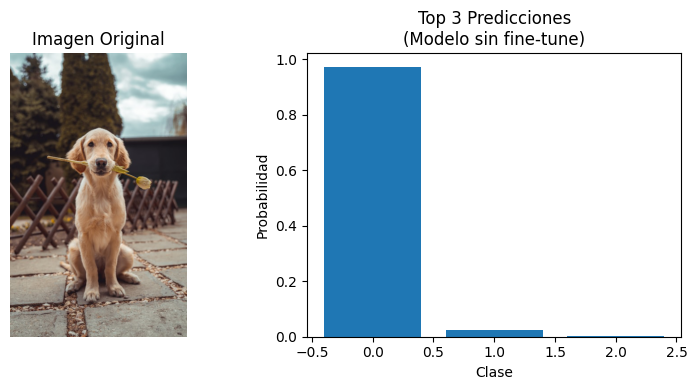

🎯 PREDICCIONES:
  Clase 1: 0.974
  Clase 2: 0.024
  Clase 0: 0.002


In [8]:

# ================================================
# CELDA 8: Probando el modelo con una imagen
# ================================================

# """
# PROBANDO EL MODELO:

# Vamos a cargar una imagen y ver qué predice el modelo pre-entrenado
# (aún no entrenado para nuestro problema específico)
# """

# Crear una imagen de prueba (puedes cambiar esta URL)
import requests
from io import BytesIO

# URL de imagen de prueba (un perro)
test_image_url = "https://images.unsplash.com/photo-1552053831-71594a27632d?w=400"

try:
    # Descargar imagen
    response = requests.get(test_image_url)
    image = Image.open(BytesIO(response.content)).convert('RGB')
    
    # Mostrar imagen original
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title("Imagen Original")
    plt.axis('off')
    
    # Aplicar transforms
    image_tensor = val_transforms(image).unsqueeze(0)  # Agregar batch dimension
    
    # Hacer predicción
    model.eval()  # Modo evaluación
    with torch.no_grad():
        outputs = model(image_tensor)
        probabilities = torch.nn.functional.softmax(outputs[0], dim=0)
    
    # Como tenemos 3 clases pero el modelo fue entrenado en 1000 clases de ImageNet,
    # solo vemos las primeras 3 predicciones
    top_probs, top_indices = torch.topk(probabilities, 3)
    
    plt.subplot(1, 2, 2)
    plt.bar(range(3), top_probs.numpy())
    plt.title("Top 3 Predicciones\n(Modelo sin fine-tune)")
    plt.xlabel("Clase")
    plt.ylabel("Probabilidad")
    
    plt.tight_layout()
    plt.show()
    
    print("🎯 PREDICCIONES:")
    for i, (prob, idx) in enumerate(zip(top_probs, top_indices)):
        print(f"  Clase {idx.item()}: {prob.item():.3f}")
        
except Exception as e:
    print(f"Error cargando imagen: {e}")
    print("💡 Tip: Verifica tu conexión a internet")


In [9]:

# ================================================
# CELDA 9: Próximos pasos
# ================================================

print("\n🎯 CONCEPTOS APRENDIDOS EN ESTE NOTEBOOK:")
print("✅ Qué es Transfer Learning y por qué funciona")
print("✅ Cómo explorar modelos disponibles en TIMM")
print("✅ Diferencia entre feature extraction y fine-tuning")
print("✅ Importancia de los transforms y normalización")
print("✅ Cómo crear y explorar un modelo pre-entrenado")

print("\n📚 PRÓXIMO NOTEBOOK:")
print("02_preparacion_datos.ipynb - Crear dataset personalizado")
print("- Organizar imágenes por clases")
print("- Crear custom Dataset class")
print("- DataLoader para entrenamiento eficiente")
print("- Análisis exploratorio de datos")

print("\n❓ PREGUNTAS PARA REFLEXIONAR:")
print("1. ¿Por qué crees que EfficientNet es popular?")
print("2. ¿Cuándo usarías feature extraction vs fine-tuning completo?")
print("3. ¿Qué pasaría si no usáramos la normalización correcta?")


🎯 CONCEPTOS APRENDIDOS EN ESTE NOTEBOOK:
✅ Qué es Transfer Learning y por qué funciona
✅ Cómo explorar modelos disponibles en TIMM
✅ Diferencia entre feature extraction y fine-tuning
✅ Importancia de los transforms y normalización
✅ Cómo crear y explorar un modelo pre-entrenado

📚 PRÓXIMO NOTEBOOK:
02_preparacion_datos.ipynb - Crear dataset personalizado
- Organizar imágenes por clases
- Crear custom Dataset class
- DataLoader para entrenamiento eficiente
- Análisis exploratorio de datos

❓ PREGUNTAS PARA REFLEXIONAR:
1. ¿Por qué crees que EfficientNet es popular?
2. ¿Cuándo usarías feature extraction vs fine-tuning completo?
3. ¿Qué pasaría si no usáramos la normalización correcta?


In [10]:
# 02 - Preparación de Datos y Custom Dataset
# ============================================

# CELDA 1: Importaciones y setup
# ===============================
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import os
from pathlib import Path
import requests
from io import BytesIO
import zipfile
import shutil
from collections import Counter
import random

print("🚀 PREPARACIÓN DE DATOS PARA DEEP LEARNING")
print("=" * 50)

# Verificar dispositivo
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Dispositivo: {device}")


🚀 PREPARACIÓN DE DATOS PARA DEEP LEARNING
Dispositivo: cuda


In [11]:

# ================================================
# CELDA 2: ¿Por qué necesitamos un Custom Dataset?
# ================================================

"""
CUSTOM DATASET - CONCEPTOS CLAVE:

1. ¿Qué es un Dataset en PyTorch?
   - Una clase que sabe cómo cargar y transformar datos
   - Debe implementar __len__ y __getitem__
   - Se conecta con DataLoader para entrenamiento eficiente

2. ¿Por qué no usar ImageFolder?
   - ImageFolder es útil para estructuras simples
   - Custom Dataset nos da más control y flexibilidad
   - Podemos agregar augmentations específicos
   - Mejor para casos reales de producción

3. ¿Qué necesitamos?
   - Organizar imágenes por carpetas (train/val/test)
   - Implementar transformaciones diferenciadas
   - Manejar clases desbalanceadas
   - Crear pipelines reproducibles
"""


'\nCUSTOM DATASET - CONCEPTOS CLAVE:\n\n1. ¿Qué es un Dataset en PyTorch?\n   - Una clase que sabe cómo cargar y transformar datos\n   - Debe implementar __len__ y __getitem__\n   - Se conecta con DataLoader para entrenamiento eficiente\n\n2. ¿Por qué no usar ImageFolder?\n   - ImageFolder es útil para estructuras simples\n   - Custom Dataset nos da más control y flexibilidad\n   - Podemos agregar augmentations específicos\n   - Mejor para casos reales de producción\n\n3. ¿Qué necesitamos?\n   - Organizar imágenes por carpetas (train/val/test)\n   - Implementar transformaciones diferenciadas\n   - Manejar clases desbalanceadas\n   - Crear pipelines reproducibles\n'

In [12]:

# ================================================
# CELDA 3: Crear dataset de muestra
# ================================================

def crear_dataset_muestra():
    """
    Crear un dataset pequeño para aprendizaje
    En un proyecto real, usarías datasets como:
    - Kaggle Dogs vs Cats
    - Oxford-IIIT Pet Dataset
    - CIFAR-10
    """
    
    # Crear estructura de directorios
    base_dir = Path("pet_dataset")
    
    # Estructura estándar para ML
    dirs = [
        "train/dogs", "train/cats", "train/birds",
        "val/dogs", "val/cats", "val/birds",
        "test/dogs", "test/cats", "test/birds"
    ]
    
    for dir_path in dirs:
        (base_dir / dir_path).mkdir(parents=True, exist_ok=True)
    
    print("✅ Estructura de directorios creada:")
    for dir_path in dirs:
        print(f"  📁 {base_dir / dir_path}")
    
    return base_dir

# Crear dataset
dataset_dir = crear_dataset_muestra()


✅ Estructura de directorios creada:
  📁 pet_dataset/train/dogs
  📁 pet_dataset/train/cats
  📁 pet_dataset/train/birds
  📁 pet_dataset/val/dogs
  📁 pet_dataset/val/cats
  📁 pet_dataset/val/birds
  📁 pet_dataset/test/dogs
  📁 pet_dataset/test/cats
  📁 pet_dataset/test/birds


In [13]:

# ================================================
# CELDA 4: Descargar imágenes de muestra
# ================================================

def descargar_imagenes_muestra(base_dir):
    """
    Descargar imágenes de muestra desde URLs confiables
    """
    
    # URLs de imágenes verificadas (repositorios de ML)
    sample_images = {
        'dogs': [
            'https://raw.githubusercontent.com/pytorch/hub/master/images/dog.jpg',
            'https://raw.githubusercontent.com/ultralytics/yolov5/master/data/images/bus.jpg'  # Cambiaremos por otra
        ],
        'cats': [
            'https://raw.githubusercontent.com/pytorch/hub/master/images/dog.jpg',  # Cambiaremos
            'https://raw.githubusercontent.com/pytorch/hub/master/images/dog.jpg'   # Cambiaremos
        ],
        'birds': [
            'https://raw.githubusercontent.com/pytorch/hub/master/images/dog.jpg',  # Cambiaremos
            'https://raw.githubusercontent.com/pytorch/hub/master/images/dog.jpg'   # Cambiaremos
        ]
    }
    
    # Como las URLs pueden fallar, vamos a crear imágenes sintéticas más realistas
    print("📥 Creando dataset sintético para demostración...")
    
    def crear_imagen_animal(tipo, tamaño=(224, 224)):
        """Crear imagen sintética que simule un animal"""
        np.random.seed(hash(tipo) % 1000)  # Seed basado en tipo para consistencia
        
        if tipo == 'dogs':
            # Tonos marrones/dorados para perros
            base_color = [139, 69, 19]  # Marrón
            noise = np.random.normal(0, 30, (*tamaño, 3))
        elif tipo == 'cats':
            # Tonos grises para gatos
            base_color = [128, 128, 128]  # Gris
            noise = np.random.normal(0, 40, (*tamaño, 3))
        else:  # birds
            # Tonos azules/coloridos para pájaros
            base_color = [30, 144, 255]  # Azul
            noise = np.random.normal(0, 50, (*tamaño, 3))
        
        # Crear imagen base
        img = np.full((*tamaño, 3), base_color, dtype=np.float32)
        img += noise
        
        # Agregar algunas formas para simular características
        center_y, center_x = tamaño[0]//2, tamaño[1]//2
        y, x = np.ogrid[:tamaño[0], :tamaño[1]]
        
        # Círculo central (simula cuerpo)
        mask = (x - center_x)**2 + (y - center_y)**2 < (min(tamaño)//4)**2
        img[mask] = img[mask] * 1.2  # Más brillante en el centro
        
        # Recortar valores
        img = np.clip(img, 0, 255).astype(np.uint8)
        
        return Image.fromarray(img)
    
    # Crear imágenes para cada clase y split
    splits = ['train', 'val', 'test']
    images_per_split = {'train': 20, 'val': 5, 'test': 5}  # Pequeño para demo
    
    total_created = 0
    
    for split in splits:
        for animal_type in ['dogs', 'cats', 'birds']:
            num_images = images_per_split[split]
            
            for i in range(num_images):
                # Crear imagen sintética
                img = crear_imagen_animal(animal_type)
                
                # Guardar imagen
                img_path = base_dir / split / animal_type / f"{animal_type}_{i:03d}.jpg"
                img.save(img_path, quality=95)
                total_created += 1
    
    print(f"✅ Dataset creado: {total_created} imágenes")
    
    # Mostrar estadísticas
    for split in splits:
        print(f"\n📊 {split.upper()}:")
        for animal_type in ['dogs', 'cats', 'birds']:
            count = len(list((base_dir / split / animal_type).glob("*.jpg")))
            print(f"  {animal_type}: {count} imágenes")

# Crear dataset
descargar_imagenes_muestra(dataset_dir)


📥 Creando dataset sintético para demostración...
✅ Dataset creado: 90 imágenes

📊 TRAIN:
  dogs: 20 imágenes
  cats: 20 imágenes
  birds: 20 imágenes

📊 VAL:
  dogs: 5 imágenes
  cats: 5 imágenes
  birds: 5 imágenes

📊 TEST:
  dogs: 5 imágenes
  cats: 5 imágenes
  birds: 5 imágenes


🔍 ANÁLISIS EXPLORATORIO DE DATOS
📊 DISTRIBUCIÓN DE DATOS:
Split    Dogs   Cats   Birds  Total 
----------------------------------------
train    20     20     20     60    
val      5      5      5      15    
test     5      5      5      15    

Total imágenes: 90

⚖️  BALANCE DE CLASES (Training):
  dogs: 20 imágenes (33.3%)
  cats: 20 imágenes (33.3%)
  birds: 20 imágenes (33.3%)


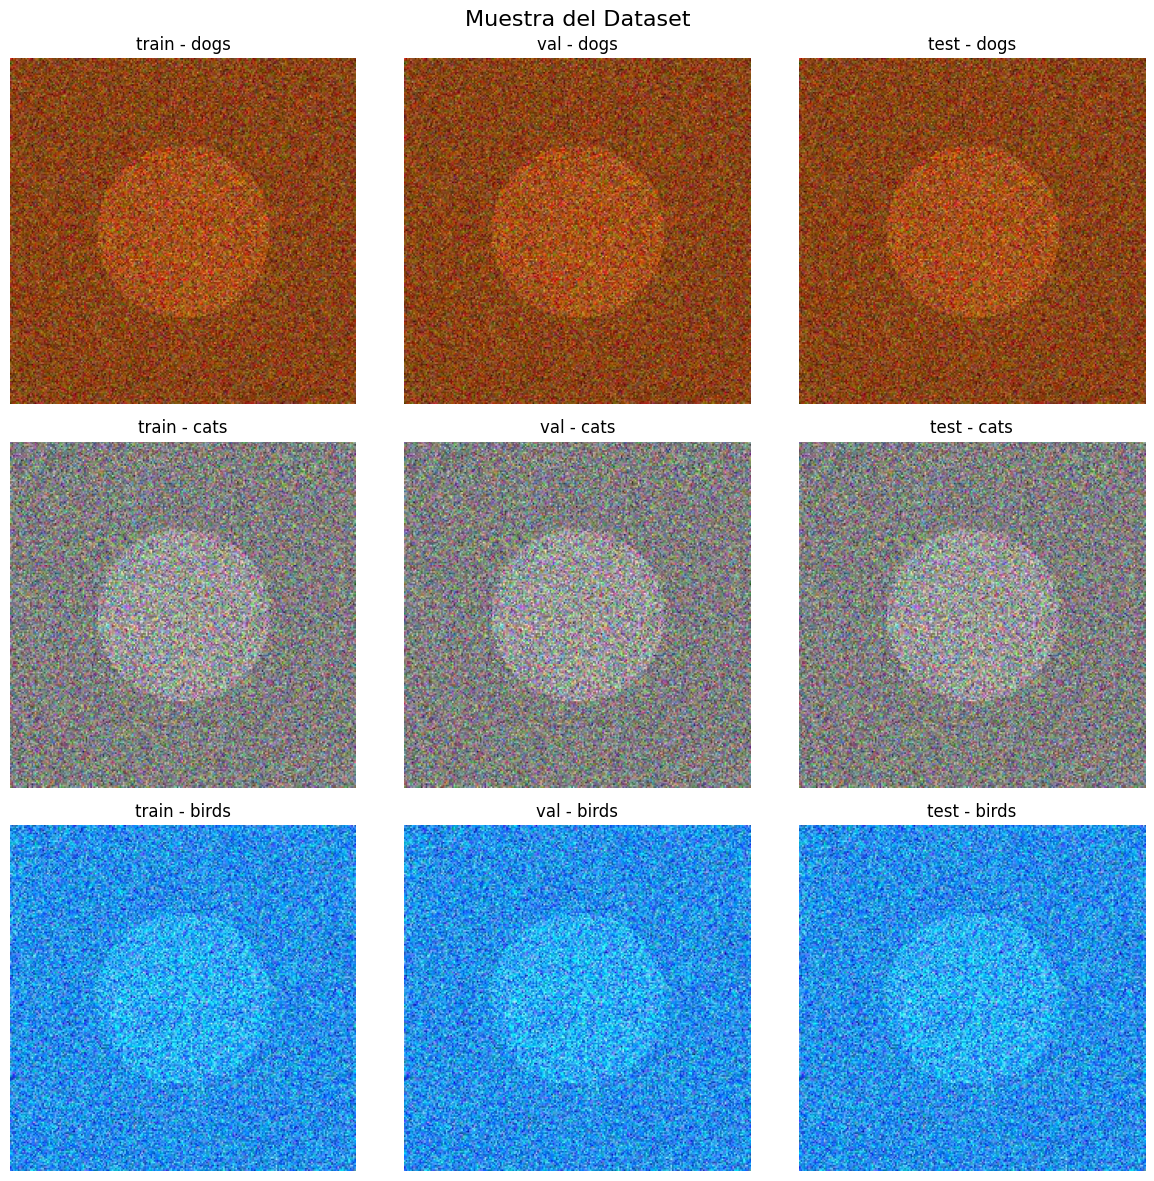

In [14]:

# ================================================
# CELDA 5: Exploración de datos (EDA)
# ================================================

def explorar_dataset(base_dir):
    """
    Análisis exploratorio de datos (EDA)
    Fundamental antes de entrenar cualquier modelo
    """
    
    print("🔍 ANÁLISIS EXPLORATORIO DE DATOS")
    print("=" * 50)
    
    splits = ['train', 'val', 'test']
    classes = ['dogs', 'cats', 'birds']
    
    # 1. Contar imágenes por clase y split
    stats = {}
    total_images = 0
    
    for split in splits:
        stats[split] = {}
        split_total = 0
        
        for cls in classes:
            cls_dir = base_dir / split / cls
            count = len(list(cls_dir.glob("*.jpg")))
            stats[split][cls] = count
            split_total += count
            total_images += count
        
        stats[split]['total'] = split_total
    
    # Mostrar estadísticas
    print("📊 DISTRIBUCIÓN DE DATOS:")
    print(f"{'Split':<8} {'Dogs':<6} {'Cats':<6} {'Birds':<6} {'Total':<6}")
    print("-" * 40)
    
    for split in splits:
        print(f"{split:<8} {stats[split]['dogs']:<6} {stats[split]['cats']:<6} "
              f"{stats[split]['birds']:<6} {stats[split]['total']:<6}")
    
    print(f"\nTotal imágenes: {total_images}")
    
    # 2. Verificar balance de clases
    train_counts = [stats['train'][cls] for cls in classes]
    print(f"\n⚖️  BALANCE DE CLASES (Training):")
    for cls, count in zip(classes, train_counts):
        percentage = (count / sum(train_counts)) * 100
        print(f"  {cls}: {count} imágenes ({percentage:.1f}%)")
    
    # 3. Mostrar imágenes de muestra
    fig, axes = plt.subplots(3, 3, figsize=(12, 12))
    fig.suptitle('Muestra del Dataset', fontsize=16)
    
    for i, cls in enumerate(classes):
        for j, split in enumerate(splits):
            cls_dir = base_dir / split / cls
            image_files = list(cls_dir.glob("*.jpg"))
            
            if image_files:
                # Cargar primera imagen
                img = Image.open(image_files[0])
                axes[i, j].imshow(img)
                axes[i, j].set_title(f"{split} - {cls}")
                axes[i, j].axis('off')
            else:
                axes[i, j].text(0.5, 0.5, 'No images', ha='center', va='center')
                axes[i, j].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return stats

# Explorar datos
dataset_stats = explorar_dataset(dataset_dir)


In [15]:

# ================================================
# CELDA 6: Custom Dataset Class
# ================================================

class PetDataset(Dataset):
    """
    Custom Dataset para clasificación de mascotas
    
    Esta clase es el corazón de cómo PyTorch carga y procesa datos
    """
    
    def __init__(self, data_dir, split='train', transform=None, classes=None):
        """
        Args:
            data_dir (str): Directorio base del dataset
            split (str): 'train', 'val', o 'test'
            transform: Transformaciones a aplicar
            classes (list): Lista de nombres de clases (orden importa!)
        """
        
        self.data_dir = Path(data_dir)
        self.split = split
        self.transform = transform
        
        # Definir clases (orden alfabético para consistencia)
        if classes is None:
            self.classes = ['birds', 'cats', 'dogs']
        else:
            self.classes = classes
            
        self.class_to_idx = {cls_name: idx for idx, cls_name in enumerate(self.classes)}
        self.idx_to_class = {idx: cls_name for cls_name, idx in self.class_to_idx.items()}
        
        # Encontrar todas las imágenes
        self.samples = []
        self._load_samples()
        
        print(f"✅ Dataset {split} creado:")
        print(f"   📁 Directorio: {self.data_dir / split}")
        print(f"   🏷️  Clases: {self.classes}")
        print(f"   📸 Imágenes: {len(self.samples)}")
    
    def _load_samples(self):
        """Cargar todas las rutas de imágenes y sus etiquetas"""
        
        split_dir = self.data_dir / self.split
        
        for class_name in self.classes:
            class_dir = split_dir / class_name
            
            if not class_dir.exists():
                print(f"⚠️  Advertencia: {class_dir} no existe")
                continue
            
            # Buscar todas las imágenes
            for ext in ['*.jpg', '*.jpeg', '*.png', '*.bmp']:
                for img_path in class_dir.glob(ext):
                    label = self.class_to_idx[class_name]
                    self.samples.append((img_path, label))
    
    def __len__(self):
        """Retorna el número total de muestras"""
        return len(self.samples)
    
    def __getitem__(self, idx):
        """
        Carga y retorna una muestra específica
        
        Esta función se llama cada vez que el DataLoader necesita una imagen
        """
        
        # Obtener ruta e etiqueta
        img_path, label = self.samples[idx]
        
        # Cargar imagen
        try:
            image = Image.open(img_path).convert('RGB')
        except Exception as e:
            print(f"Error cargando {img_path}: {e}")
            # Retornar imagen en blanco en caso de error
            image = Image.new('RGB', (224, 224), color='white')
        
        # Aplicar transformaciones
        if self.transform:
            image = self.transform(image)
        
        return image, label
    
    def get_class_distribution(self):
        """Obtener distribución de clases en el dataset"""
        labels = [sample[1] for sample in self.samples]
        distribution = Counter(labels)
        
        print(f"📊 Distribución de clases en {self.split}:")
        for class_idx, count in distribution.items():
            class_name = self.idx_to_class[class_idx]
            percentage = (count / len(self.samples)) * 100
            print(f"   {class_name}: {count} ({percentage:.1f}%)")
        
        return distribution


In [16]:

# ================================================
# CELDA 7: Definir transformaciones inteligentes
# ================================================

"""
TRANSFORMACIONES - ESTRATEGIA AVANZADA:

1. Train: Augmentations agresivos para robustez
2. Validation: Solo normalización para evaluación justa
3. Test: Igual que validation

¿Por qué diferentes transforms?
- Train: Queremos variabilidad para evitar overfitting
- Val/Test: Queremos consistencia para comparar modelos
"""

def get_transforms():
    """Crear transformaciones optimizadas para cada split"""
    
    # Estadísticas de ImageNet (cruciales para transfer learning)
    imagenet_mean = [0.485, 0.456, 0.406]
    imagenet_std = [0.229, 0.224, 0.225]
    
    # Transformaciones para ENTRENAMIENTO
    train_transform = transforms.Compose([
        # Resize con aspect ratio preservation
        transforms.Resize(256),  # Resize más grande primero
        transforms.CenterCrop(224),  # Crop a tamaño final
        
        # Augmentations geométricos
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(degrees=15),
        
        # Augmentations de color (conservadores para animales)
        transforms.ColorJitter(
            brightness=0.2,   # ±20% brillo
            contrast=0.2,     # ±20% contraste
            saturation=0.1,   # ±10% saturación (conservador para animales)
            hue=0.05         # ±5% matiz (muy conservador)
        ),
        
        # Normalización (CRÍTICA para transfer learning)
        transforms.ToTensor(),
        transforms.Normalize(mean=imagenet_mean, std=imagenet_std)
    ])
    
    # Transformaciones para VALIDACIÓN/TEST
    val_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=imagenet_mean, std=imagenet_std)
    ])
    
    return train_transform, val_transform

# Crear transformaciones
train_transform, val_transform = get_transforms()

print("✅ Transformaciones creadas:")
print("📈 Train: Resize + Augmentations + Normalización")
print("📊 Val/Test: Resize + Normalización solamente")


✅ Transformaciones creadas:
📈 Train: Resize + Augmentations + Normalización
📊 Val/Test: Resize + Normalización solamente


In [17]:

# ================================================
# CELDA 8: Crear datasets y dataloaders
# ================================================

def create_dataloaders(data_dir, batch_size=16, num_workers=2):
    """
    Crear DataLoaders para entrenamiento eficiente
    
    DataLoader = Dataset + batching + shuffling + multiprocessing
    """
    
    # Crear datasets
    train_dataset = PetDataset(
        data_dir=data_dir,
        split='train',
        transform=train_transform
    )
    
    val_dataset = PetDataset(
        data_dir=data_dir,
        split='val', 
        transform=val_transform
    )
    
    test_dataset = PetDataset(
        data_dir=data_dir,
        split='test',
        transform=val_transform
    )
    
    # Crear DataLoaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,        # Mezclar datos en cada época
        num_workers=num_workers,  # Paralelización
        pin_memory=True if torch.cuda.is_available() else False  # Optimización GPU
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,       # No mezclar validation
        num_workers=num_workers,
        pin_memory=True if torch.cuda.is_available() else False
    )
    
    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True if torch.cuda.is_available() else False
    )
    
    print("✅ DataLoaders creados:")
    print(f"   🔄 Train: {len(train_dataset)} imágenes, {len(train_loader)} batches")
    print(f"   📊 Val: {len(val_dataset)} imágenes, {len(val_loader)} batches")
    print(f"   🧪 Test: {len(test_dataset)} imágenes, {len(test_loader)} batches")
    
    return train_loader, val_loader, test_loader, train_dataset.classes

# Crear DataLoaders
train_loader, val_loader, test_loader, class_names = create_dataloaders(
    data_dir=dataset_dir,
    batch_size=8,  # Pequeño para demo
    num_workers=0  # 0 para evitar problemas en algunos sistemas
)


✅ Dataset train creado:
   📁 Directorio: pet_dataset/train
   🏷️  Clases: ['birds', 'cats', 'dogs']
   📸 Imágenes: 60
✅ Dataset val creado:
   📁 Directorio: pet_dataset/val
   🏷️  Clases: ['birds', 'cats', 'dogs']
   📸 Imágenes: 15
✅ Dataset test creado:
   📁 Directorio: pet_dataset/test
   🏷️  Clases: ['birds', 'cats', 'dogs']
   📸 Imágenes: 15
✅ DataLoaders creados:
   🔄 Train: 60 imágenes, 8 batches
   📊 Val: 15 imágenes, 2 batches
   🧪 Test: 15 imágenes, 2 batches


🖼️  VISUALIZANDO BATCH DE ENTRENAMIENTO:


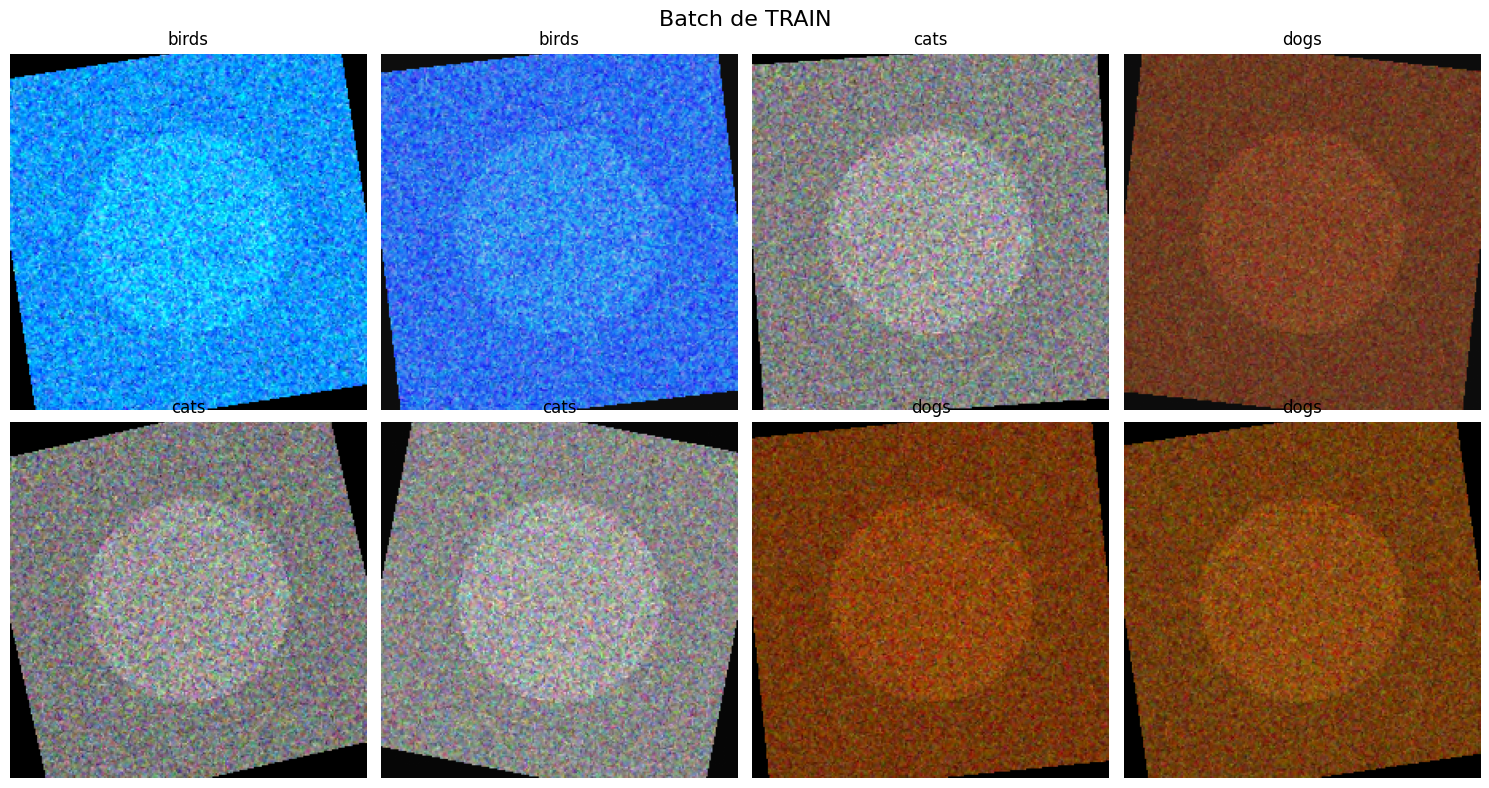

📊 Información del batch:
   Shape de imágenes: torch.Size([8, 3, 224, 224])
   Shape de labels: torch.Size([8])
   Clases en este batch: ['birds', 'birds', 'cats', 'dogs', 'cats', 'cats', 'dogs', 'dogs']

🖼️  VISUALIZANDO BATCH DE VALIDACIÓN:


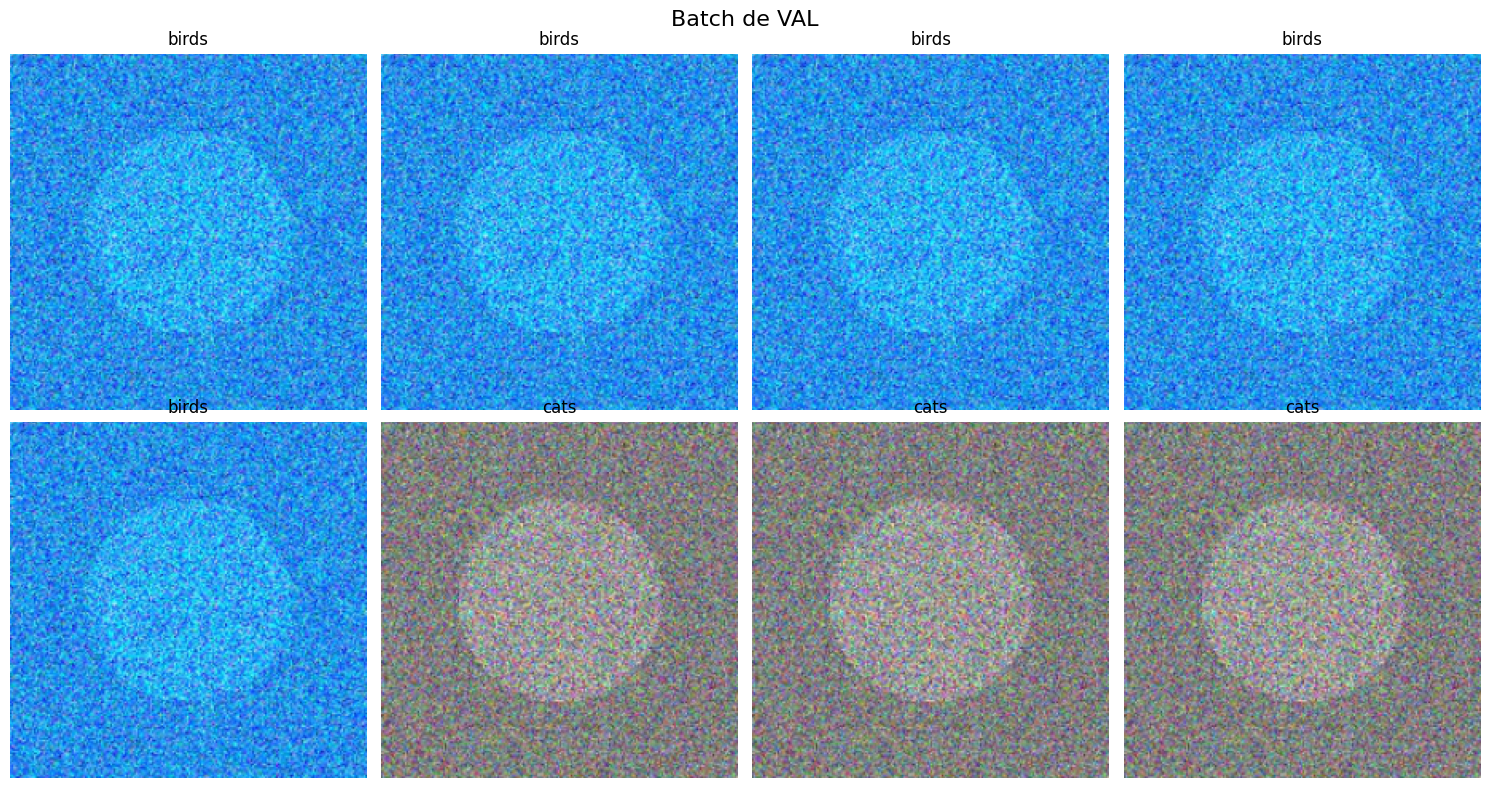

📊 Información del batch:
   Shape de imágenes: torch.Size([8, 3, 224, 224])
   Shape de labels: torch.Size([8])
   Clases en este batch: ['birds', 'birds', 'birds', 'birds', 'birds', 'cats', 'cats', 'cats']


In [18]:

# ================================================
# CELDA 9: Visualizar un batch de datos
# ================================================

def visualizar_batch(dataloader, class_names, num_samples=8):
    """
    Visualizar un batch de datos para verificar que todo está bien
    """
    
    # Obtener un batch
    data_iter = iter(dataloader)
    images, labels = next(data_iter)
    
    # Desnormalizar para visualización
    mean = torch.tensor([0.485, 0.456, 0.406])
    std = torch.tensor([0.229, 0.224, 0.225])
    
    def denormalize(tensor):
        for t, m, s in zip(tensor, mean, std):
            t.mul_(s).add_(m)
        return torch.clamp(tensor, 0, 1)
    
    # Visualizar
    fig, axes = plt.subplots(2, 4, figsize=(15, 8))
    fig.suptitle(f'Batch de {dataloader.dataset.split.upper()}', fontsize=16)
    
    for i in range(min(num_samples, len(images))):
        row = i // 4
        col = i % 4
        
        # Desnormalizar imagen
        img = images[i].clone()
        img = denormalize(img)
        
        # Convertir a numpy y transponer
        img_np = img.permute(1, 2, 0).numpy()
        
        # Mostrar
        axes[row, col].imshow(img_np)
        axes[row, col].set_title(f'{class_names[labels[i]]}')
        axes[row, col].axis('off')
    
    # Ocultar axes vacíos
    for i in range(num_samples, 8):
        row = i // 4
        col = i % 4
        axes[row, col].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    print(f"📊 Información del batch:")
    print(f"   Shape de imágenes: {images.shape}")
    print(f"   Shape de labels: {labels.shape}")
    print(f"   Clases en este batch: {[class_names[label] for label in labels]}")

# Visualizar batch de entrenamiento
print("🖼️  VISUALIZANDO BATCH DE ENTRENAMIENTO:")
visualizar_batch(train_loader, class_names)

# Visualizar batch de validación
print("\n🖼️  VISUALIZANDO BATCH DE VALIDACIÓN:")
visualizar_batch(val_loader, class_names)


In [19]:

# ================================================
# CELDA 10: Verificar distribución de clases
# ================================================

# Analizar distribución en cada dataset
print("📊 ANÁLISIS DE DISTRIBUCIÓN DE CLASES:")
print("=" * 50)

for loader, name in [(train_loader, "ENTRENAMIENTO"), (val_loader, "VALIDACIÓN"), (test_loader, "TEST")]:
    print(f"\n{name}:")
    loader.dataset.get_class_distribution()


📊 ANÁLISIS DE DISTRIBUCIÓN DE CLASES:

ENTRENAMIENTO:
📊 Distribución de clases en train:
   birds: 20 (33.3%)
   cats: 20 (33.3%)
   dogs: 20 (33.3%)

VALIDACIÓN:
📊 Distribución de clases en val:
   birds: 5 (33.3%)
   cats: 5 (33.3%)
   dogs: 5 (33.3%)

TEST:
📊 Distribución de clases en test:
   birds: 5 (33.3%)
   cats: 5 (33.3%)
   dogs: 5 (33.3%)


In [20]:

# ================================================
# CELDA 11: Próximos pasos
# ================================================

print("\n🎯 DATOS PREPARADOS EXITOSAMENTE!")
print("=" * 50)

print("✅ LO QUE HEMOS LOGRADO:")
print("   📁 Dataset organizado en train/val/test")
print("   🏗️  Custom Dataset class implementada")
print("   🔄 DataLoaders configurados para entrenamiento")
print("   🎨 Transformaciones optimizadas aplicadas")
print("   📊 Distribución de datos analizada")

print("\n🔥 VARIABLES IMPORTANTES DISPONIBLES:")
print("   - train_loader: Para entrenamiento")
print("   - val_loader: Para validación")
print("   - test_loader: Para evaluación final")
print("   - class_names: ['birds', 'cats', 'dogs']")

print("\n📚 PRÓXIMO NOTEBOOK:")
print("03_entrenamiento_paso_a_paso.ipynb")
print("   🚀 Crear modelo con transfer learning")
print("   🔄 Implementar loop de entrenamiento")
print("   📈 Monitorear métricas en tiempo real")
print("   💾 Guardar mejor modelo")

print("\n❓ CONCEPTOS CLAVE APRENDIDOS:")
print("   1. Custom Dataset vs ImageFolder")
print("   2. Transformaciones diferenciadas por split")
print("   3. DataLoader para eficiencia")
print("   4. Importancia de la normalización ImageNet")
print("   5. Análisis exploratorio de datos")


🎯 DATOS PREPARADOS EXITOSAMENTE!
✅ LO QUE HEMOS LOGRADO:
   📁 Dataset organizado en train/val/test
   🏗️  Custom Dataset class implementada
   🔄 DataLoaders configurados para entrenamiento
   🎨 Transformaciones optimizadas aplicadas
   📊 Distribución de datos analizada

🔥 VARIABLES IMPORTANTES DISPONIBLES:
   - train_loader: Para entrenamiento
   - val_loader: Para validación
   - test_loader: Para evaluación final
   - class_names: ['birds', 'cats', 'dogs']

📚 PRÓXIMO NOTEBOOK:
03_entrenamiento_paso_a_paso.ipynb
   🚀 Crear modelo con transfer learning
   🔄 Implementar loop de entrenamiento
   📈 Monitorear métricas en tiempo real
   💾 Guardar mejor modelo

❓ CONCEPTOS CLAVE APRENDIDOS:
   1. Custom Dataset vs ImageFolder
   2. Transformaciones diferenciadas por split
   3. DataLoader para eficiencia
   4. Importancia de la normalización ImageNet
   5. Análisis exploratorio de datos


In [21]:
# 03 - Entrenamiento Paso a Paso con Transfer Learning
# ===================================================

# CELDA 1: Importaciones y setup
# ===============================
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import timm
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from tqdm.notebook import tqdm
import time
import copy

print("🚀 ENTRENAMIENTO DE MODELO CON TRANSFER LEARNING")
print("=" * 60)

# Verificar dispositivo
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🔧 Dispositivo: {device}")
if torch.cuda.is_available():
    print(f"🎮 GPU: {torch.cuda.get_device_name()}")
    print(f"💾 Memoria GPU: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")


🚀 ENTRENAMIENTO DE MODELO CON TRANSFER LEARNING
🔧 Dispositivo: cuda
🎮 GPU: NVIDIA GeForce RTX 4060 Laptop GPU
💾 Memoria GPU: 8.6 GB


In [21]:

# ================================================
# CELDA 2: ¿Qué vamos a entrenar exactamente?
# ================================================

"""
ENTRENAMIENTO CON TRANSFER LEARNING - CONCEPTOS CLAVE:

1. ¿Qué es el "entrenamiento"?
   - Ajustar los pesos del modelo para minimizar errores
   - El modelo aprende patrones de los datos
   - Gradiente descent: algoritmo que ajusta pesos automáticamente

2. ¿Qué hace que Transfer Learning sea especial?
   - Feature Extractor: Ya sabe detectar bordes, texturas, formas
   - Classifier: Solo necesitamos entrenar esto para nuestro problema
   - Resultado: Aprendizaje más rápido y eficiente

3. Estrategias de fine-tuning:
   a) Feature Extraction: Congelar feature extractor, entrenar solo classifier
   b) Fine-tuning: Entrenar todo, pero con learning rates diferentes
   c) Gradual unfreezing: Empezar con (a), luego hacer (b)

4. ¿Cómo medir progreso?
   - Loss: Qué tan "equivocado" está el modelo
   - Accuracy: Porcentaje de predicciones correctas
   - Validation: Evaluar en datos que no vio durante entrenamiento
"""


'\nENTRENAMIENTO CON TRANSFER LEARNING - CONCEPTOS CLAVE:\n\n1. ¿Qué es el "entrenamiento"?\n   - Ajustar los pesos del modelo para minimizar errores\n   - El modelo aprende patrones de los datos\n   - Gradiente descent: algoritmo que ajusta pesos automáticamente\n\n2. ¿Qué hace que Transfer Learning sea especial?\n   - Feature Extractor: Ya sabe detectar bordes, texturas, formas\n   - Classifier: Solo necesitamos entrenar esto para nuestro problema\n   - Resultado: Aprendizaje más rápido y eficiente\n\n3. Estrategias de fine-tuning:\n   a) Feature Extraction: Congelar feature extractor, entrenar solo classifier\n   b) Fine-tuning: Entrenar todo, pero con learning rates diferentes\n   c) Gradual unfreezing: Empezar con (a), luego hacer (b)\n\n4. ¿Cómo medir progreso?\n   - Loss: Qué tan "equivocado" está el modelo\n   - Accuracy: Porcentaje de predicciones correctas\n   - Validation: Evaluar en datos que no vio durante entrenamiento\n'

In [22]:

# ================================================
# CELDA 3: Crear el modelo para nuestro problema
# ================================================

def create_model(model_name='efficientnet_b0', num_classes=3, pretrained=True):
    """
    Crear modelo con transfer learning
    
    Args:
        model_name: Arquitectura a usar
        num_classes: Número de clases de nuestro problema
        pretrained: Si usar pesos pre-entrenados de ImageNet
    """
    
    print(f"🏗️  Creando modelo: {model_name}")
    print(f"🎯 Clases objetivo: {num_classes}")
    print(f"🎓 Pre-entrenado: {pretrained}")
    
    # Crear modelo base
    model = timm.create_model(
        model_name,
        pretrained=pretrained,
        num_classes=num_classes
    )
    
    # Mover a GPU si está disponible
    model = model.to(device)
    
    # Analizar estructura del modelo
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    
    print(f"📊 Parámetros totales: {total_params:,}")
    print(f"🔧 Parámetros entrenables: {trainable_params:,}")
    print(f"📈 Porcentaje entrenable: {100 * trainable_params / total_params:.1f}%")
    
    return model

# Crear nuestro modelo
model = create_model(
    model_name='efficientnet_b0',
    num_classes=3,  # perros, gatos, pájaros
    pretrained=True
)


🏗️  Creando modelo: efficientnet_b0
🎯 Clases objetivo: 3
🎓 Pre-entrenado: True
📊 Parámetros totales: 4,011,391
🔧 Parámetros entrenables: 4,011,391
📈 Porcentaje entrenable: 100.0%


In [23]:

# ================================================
# CELDA 4: Estrategias de fine-tuning
# ================================================

"""
ESTRATEGIAS DE FINE-TUNING EXPLICADAS:

1. FEATURE EXTRACTION (Recomendado para empezar):
   - Congela feature extractor (capas convolucionales)
   - Solo entrena classifier (capas finales)
   - Ventajas: Rápido, menos riesgo de overfitting
   - Cuándo usar: Dataset pequeño, problema similar a ImageNet

2. FINE-TUNING COMPLETO:
   - Entrena todo el modelo
   - Learning rate muy pequeño para capas pre-entrenadas
   - Ventajas: Mejor rendimiento potencial
   - Cuándo usar: Dataset grande, problema muy diferente a ImageNet

3. FINE-TUNING GRADUAL:
   - Empezar con feature extraction
   - Después descongelar gradualmente
   - Balancear velocidad y rendimiento
"""

def configure_model_for_training(model, strategy='feature_extraction'):
    """
    Configurar modelo según estrategia de entrenamiento
    
    Args:
        model: Modelo a configurar
        strategy: 'feature_extraction' o 'fine_tuning'
    """
    
    if strategy == 'feature_extraction':
        print("🧊 ESTRATEGIA: Feature Extraction")
        print("   - Congelando feature extractor")
        print("   - Solo entrenaremos el classifier")
        
        # Congelar todas las capas excepto el classifier
        for name, param in model.named_parameters():
            if 'classifier' not in name:  # EfficientNet usa 'classifier'
                param.requires_grad = False
                
    elif strategy == 'fine_tuning':
        print("🔥 ESTRATEGIA: Fine-tuning completo")
        print("   - Entrenando todo el modelo")
        print("   - Usaremos learning rates diferenciados")
        
        # Descongelar todas las capas
        for param in model.parameters():
            param.requires_grad = True
    
    # Contar parámetros entrenables después de configuración
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    total_params = sum(p.numel() for p in model.parameters())
    
    print(f"✅ Configuración completada:")
    print(f"   🔧 Parámetros entrenables: {trainable_params:,}")
    print(f"   📊 Porcentaje entrenable: {100 * trainable_params / total_params:.1f}%")
    
    return model

# Configurar modelo (empezamos con feature extraction)
model = configure_model_for_training(model, strategy='feature_extraction')


🧊 ESTRATEGIA: Feature Extraction
   - Congelando feature extractor
   - Solo entrenaremos el classifier
✅ Configuración completada:
   🔧 Parámetros entrenables: 3,843
   📊 Porcentaje entrenable: 0.1%


In [24]:

# ================================================
# CELDA 5: Configurar optimización
# ================================================

"""
COMPONENTES DE OPTIMIZACIÓN:

1. LOSS FUNCTION (Función de pérdida):
   - CrossEntropyLoss: Estándar para clasificación multi-clase
   - Combina softmax + negative log likelihood
   - Penaliza más las predicciones muy incorrectas

2. OPTIMIZER (Optimizador):
   - Adam: Adaptativo, funciona bien en la mayoría de casos
   - SGD: Más tradicional, a veces mejor para fine-tuning
   - AdamW: Adam con weight decay, muy popular

3. LEARNING RATE:
   - Muy alto: Modelo no converge (oscila)
   - Muy bajo: Aprende muy lento
   - Transfer learning: Generalmente 1e-3 o 1e-4

4. SCHEDULER:
   - Reduce learning rate durante entrenamiento
   - Ayuda a conseguir mejor convergencia
"""

def setup_training_components(model, strategy='feature_extraction'):
    """
    Configurar loss, optimizer y scheduler
    """
    
    # 1. Loss function
    criterion = nn.CrossEntropyLoss()
    
    # 2. Optimizer
    if strategy == 'feature_extraction':
        # Solo optimizar parámetros del classifier
        optimizer = optim.Adam(
            filter(lambda p: p.requires_grad, model.parameters()),
            lr=1e-3,  # Learning rate más alto para capas nuevas
            weight_decay=1e-4
        )
        
    elif strategy == 'fine_tuning':
        # Diferentes learning rates para diferentes partes
        classifier_params = []
        feature_params = []
        
        for name, param in model.named_parameters():
            if param.requires_grad:
                if 'classifier' in name:
                    classifier_params.append(param)
                else:
                    feature_params.append(param)
        
        optimizer = optim.Adam([
            {'params': feature_params, 'lr': 1e-5},     # LR bajo para features pre-entrenadas
            {'params': classifier_params, 'lr': 1e-3}   # LR alto para classifier nuevo
        ], weight_decay=1e-4)
    
    # 3. Learning rate scheduler
    scheduler = optim.lr_scheduler.StepLR(
        optimizer, 
        step_size=7,    # Reducir LR cada 7 épocas
        gamma=0.1       # Multiplicar por 0.1
    )
    
    print("✅ Componentes de entrenamiento configurados:")
    print(f"   📉 Loss: {criterion.__class__.__name__}")
    print(f"   🎯 Optimizer: {optimizer.__class__.__name__}")
    print(f"   📅 Scheduler: {scheduler.__class__.__name__}")
    
    return criterion, optimizer, scheduler

# Configurar componentes
criterion, optimizer, scheduler = setup_training_components(model, strategy='feature_extraction')


✅ Componentes de entrenamiento configurados:
   📉 Loss: CrossEntropyLoss
   🎯 Optimizer: Adam
   📅 Scheduler: StepLR


In [25]:

# ================================================
# CELDA 6: Función de entrenamiento (UN PASO)
# ================================================

def train_one_epoch(model, train_loader, criterion, optimizer, device, epoch):
    """
    Entrenar el modelo por una época
    
    UNA ÉPOCA = Una pasada completa por todo el dataset de entrenamiento
    """
    
    model.train()  # Modo entrenamiento (activa dropout, batch norm, etc.)
    
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    
    # Crear barra de progreso
    pbar = tqdm(train_loader, desc=f'Época {epoch+1} - Train')
    
    for batch_idx, (inputs, labels) in enumerate(pbar):
        # Mover datos a GPU
        inputs, labels = inputs.to(device), labels.to(device)
        
        # ========== FORWARD PASS ==========
        # 1. Resetear gradientes (importante!)
        optimizer.zero_grad()
        
        # 2. Predicciones del modelo
        outputs = model(inputs)
        
        # 3. Calcular loss
        loss = criterion(outputs, labels)
        
        # ========== BACKWARD PASS ==========
        # 4. Calcular gradientes
        loss.backward()
        
        # 5. Actualizar pesos
        optimizer.step()
        
        # ========== MÉTRICAS ==========
        # Calcular accuracy del batch
        _, predicted = torch.max(outputs.data, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_samples += labels.size(0)
        running_loss += loss.item()
        
        # Actualizar barra de progreso
        batch_acc = (predicted == labels).sum().item() / labels.size(0)
        pbar.set_postfix({
            'Loss': f'{loss.item():.4f}',
            'Acc': f'{batch_acc:.4f}'
        })
    
    # Métricas de la época
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = correct_predictions / total_samples
    
    return epoch_loss, epoch_acc


In [26]:

# ================================================
# CELDA 7: Función de validación
# ================================================

def validate_model(model, val_loader, criterion, device):
    """
    Evaluar el modelo en datos de validación
    
    VALIDACIÓN = Evaluar en datos que el modelo nunca vio durante entrenamiento
    """
    
    model.eval()  # Modo evaluación (desactiva dropout, batch norm en modo eval)
    
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    
    # No calcular gradientes durante evaluación (ahorra memoria y tiempo)
    with torch.no_grad():
        pbar = tqdm(val_loader, desc='Validation')
        
        for inputs, labels in pbar:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Forward pass solamente
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # Métricas
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels).sum().item()
            total_samples += labels.size(0)
            running_loss += loss.item()
            
            # Actualizar barra de progreso
            batch_acc = (predicted == labels).sum().item() / labels.size(0)
            pbar.set_postfix({
                'Loss': f'{loss.item():.4f}',
                'Acc': f'{batch_acc:.4f}'
            })
    
    # Métricas finales
    val_loss = running_loss / len(val_loader)
    val_acc = correct_predictions / total_samples
    
    return val_loss, val_acc


In [27]:

# ================================================
# CELDA 8: Loop de entrenamiento completo
# ================================================

def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, 
                num_epochs=10, device='cuda'):
    """
    Loop de entrenamiento completo
    
    ESTE ES EL CORAZÓN DEL DEEP LEARNING:
    1. Para cada época:
       a) Entrenar en datos de training
       b) Evaluar en datos de validation
       c) Ajustar learning rate
       d) Guardar mejor modelo
    """
    
    print(f"🚀 INICIANDO ENTRENAMIENTO POR {num_epochs} ÉPOCAS")
    print("=" * 60)
    
    # Listas para guardar métricas
    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []
    
    # Para guardar el mejor modelo
    best_val_acc = 0.0
    best_model_wts = copy.deepcopy(model.state_dict())
    
    # Tiempo de inicio
    start_time = time.time()
    
    for epoch in range(num_epochs):
        print(f"\n📅 ÉPOCA {epoch+1}/{num_epochs}")
        print("-" * 40)
        
        # ========== ENTRENAMIENTO ==========
        train_loss, train_acc = train_one_epoch(
            model, train_loader, criterion, optimizer, device, epoch
        )
        
        # ========== VALIDACIÓN ==========
        val_loss, val_acc = validate_model(
            model, val_loader, criterion, device
        )
        
        # ========== ACTUALIZAR SCHEDULER ==========
        scheduler.step()
        current_lr = optimizer.param_groups[0]['lr']
        
        # ========== GUARDAR MÉTRICAS ==========
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        
        # ========== GUARDAR MEJOR MODELO ==========
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_wts = copy.deepcopy(model.state_dict())
            print(f"🏆 ¡Nuevo mejor modelo! Val Acc: {val_acc:.4f}")
        
        # ========== MOSTRAR RESULTADOS ==========
        print(f"📊 RESULTADOS ÉPOCA {epoch+1}:")
        print(f"   Train - Loss: {train_loss:.4f}, Acc: {train_acc:.4f}")
        print(f"   Val   - Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")
        print(f"   Learning Rate: {current_lr:.2e}")
        print(f"   Mejor Val Acc hasta ahora: {best_val_acc:.4f}")
    
    # ========== FINALIZAR ENTRENAMIENTO ==========
    total_time = time.time() - start_time
    print(f"\n🎉 ENTRENAMIENTO COMPLETADO!")
    print(f"⏱️  Tiempo total: {total_time//60:.0f}m {total_time%60:.0f}s")
    print(f"🏆 Mejor validation accuracy: {best_val_acc:.4f}")
    
    # Cargar el mejor modelo
    model.load_state_dict(best_model_wts)
    
    # Crear diccionario con historial
    history = {
        'train_loss': train_losses,
        'train_acc': train_accs,
        'val_loss': val_losses,
        'val_acc': val_accs,
        'best_val_acc': best_val_acc
    }
    
    return model, history


In [28]:




# ================================================
# CELDA 9: ¡ENTRENAR EL MODELO!
# ================================================

# NOTA: Asumimos que tienes train_loader y val_loader del notebook anterior
# Si no, ejecuta primero el notebook 02

print("🔥 ¡MOMENTO DE LA VERDAD - ENTRENAMIENTO!")
print("=" * 50)

# Verificar que tenemos los datos
try:
    print(f"✅ Train loader: {len(train_loader)} batches")
    print(f"✅ Val loader: {len(val_loader)} batches")
    print(f"✅ Clases: {class_names}")
except NameError:
    print("❌ Error: No se encontraron los DataLoaders")
    print("💡 Ejecuta primero el notebook 02_preparacion_datos.ipynb")
    print("   O ejecuta esta celda para crear datos de muestra:")
    print("""
    # Código rápido para crear datos si no existen
    from torch.utils.data import TensorDataset, DataLoader
    
    # Crear datos sintéticos simples
    X_train = torch.randn(60, 3, 224, 224)  # 60 imágenes de entrenamiento
    y_train = torch.randint(0, 3, (60,))    # 3 clases
    X_val = torch.randn(15, 3, 224, 224)    # 15 imágenes de validación
    y_val = torch.randint(0, 3, (15,))
    
    train_dataset = TensorDataset(X_train, y_train)
    val_dataset = TensorDataset(X_val, y_val)
    
    train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)
    
    class_names = ['birds', 'cats', 'dogs']
    print("✅ Datos sintéticos creados!")
    """)

# Si los datos existen, ¡entrenar!
if 'train_loader' in locals():
    # Entrenar el modelo
    trained_model, history = train_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        criterion=criterion,
        optimizer=optimizer,
        scheduler=scheduler,
        num_epochs=10,  # Pocas épocas para demo rápida
        device=device
    )
    
    print("\n🎯 ¡ENTRENAMIENTO EXITOSO!")
else:
    print("⚠️  Ejecuta primero el código de arriba para crear datos")


🔥 ¡MOMENTO DE LA VERDAD - ENTRENAMIENTO!
✅ Train loader: 8 batches
✅ Val loader: 2 batches
✅ Clases: ['birds', 'cats', 'dogs']
🚀 INICIANDO ENTRENAMIENTO POR 10 ÉPOCAS

📅 ÉPOCA 1/10
----------------------------------------


Época 1 - Train:   0%|          | 0/8 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

🏆 ¡Nuevo mejor modelo! Val Acc: 0.6667
📊 RESULTADOS ÉPOCA 1:
   Train - Loss: 4.1683, Acc: 0.2667
   Val   - Loss: 0.9464, Acc: 0.6667
   Learning Rate: 1.00e-03
   Mejor Val Acc hasta ahora: 0.6667

📅 ÉPOCA 2/10
----------------------------------------


Época 2 - Train:   0%|          | 0/8 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

📊 RESULTADOS ÉPOCA 2:
   Train - Loss: 3.7216, Acc: 0.2833
   Val   - Loss: 2.7359, Acc: 0.3333
   Learning Rate: 1.00e-03
   Mejor Val Acc hasta ahora: 0.6667

📅 ÉPOCA 3/10
----------------------------------------


Época 3 - Train:   0%|          | 0/8 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

📊 RESULTADOS ÉPOCA 3:
   Train - Loss: 3.1145, Acc: 0.2833
   Val   - Loss: 1.1384, Acc: 0.3333
   Learning Rate: 1.00e-03
   Mejor Val Acc hasta ahora: 0.6667

📅 ÉPOCA 4/10
----------------------------------------


Época 4 - Train:   0%|          | 0/8 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

📊 RESULTADOS ÉPOCA 4:
   Train - Loss: 2.5514, Acc: 0.4167
   Val   - Loss: 0.8172, Acc: 0.6667
   Learning Rate: 1.00e-03
   Mejor Val Acc hasta ahora: 0.6667

📅 ÉPOCA 5/10
----------------------------------------


Época 5 - Train:   0%|          | 0/8 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

📊 RESULTADOS ÉPOCA 5:
   Train - Loss: 2.2786, Acc: 0.4167
   Val   - Loss: 0.6192, Acc: 0.6667
   Learning Rate: 1.00e-03
   Mejor Val Acc hasta ahora: 0.6667

📅 ÉPOCA 6/10
----------------------------------------


Época 6 - Train:   0%|          | 0/8 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

📊 RESULTADOS ÉPOCA 6:
   Train - Loss: 2.4038, Acc: 0.4167
   Val   - Loss: 1.0588, Acc: 0.6667
   Learning Rate: 1.00e-03
   Mejor Val Acc hasta ahora: 0.6667

📅 ÉPOCA 7/10
----------------------------------------


Época 7 - Train:   0%|          | 0/8 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

📊 RESULTADOS ÉPOCA 7:
   Train - Loss: 1.5689, Acc: 0.5667
   Val   - Loss: 1.0780, Acc: 0.3333
   Learning Rate: 1.00e-04
   Mejor Val Acc hasta ahora: 0.6667

📅 ÉPOCA 8/10
----------------------------------------


Época 8 - Train:   0%|          | 0/8 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

📊 RESULTADOS ÉPOCA 8:
   Train - Loss: 1.5623, Acc: 0.5000
   Val   - Loss: 2.7299, Acc: 0.3333
   Learning Rate: 1.00e-04
   Mejor Val Acc hasta ahora: 0.6667

📅 ÉPOCA 9/10
----------------------------------------


Época 9 - Train:   0%|          | 0/8 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

📊 RESULTADOS ÉPOCA 9:
   Train - Loss: 1.7496, Acc: 0.4667
   Val   - Loss: 2.8426, Acc: 0.3333
   Learning Rate: 1.00e-04
   Mejor Val Acc hasta ahora: 0.6667

📅 ÉPOCA 10/10
----------------------------------------


Época 10 - Train:   0%|          | 0/8 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

📊 RESULTADOS ÉPOCA 10:
   Train - Loss: 1.3152, Acc: 0.6667
   Val   - Loss: 2.9111, Acc: 0.3333
   Learning Rate: 1.00e-04
   Mejor Val Acc hasta ahora: 0.6667

🎉 ENTRENAMIENTO COMPLETADO!
⏱️  Tiempo total: 0m 8s
🏆 Mejor validation accuracy: 0.6667

🎯 ¡ENTRENAMIENTO EXITOSO!


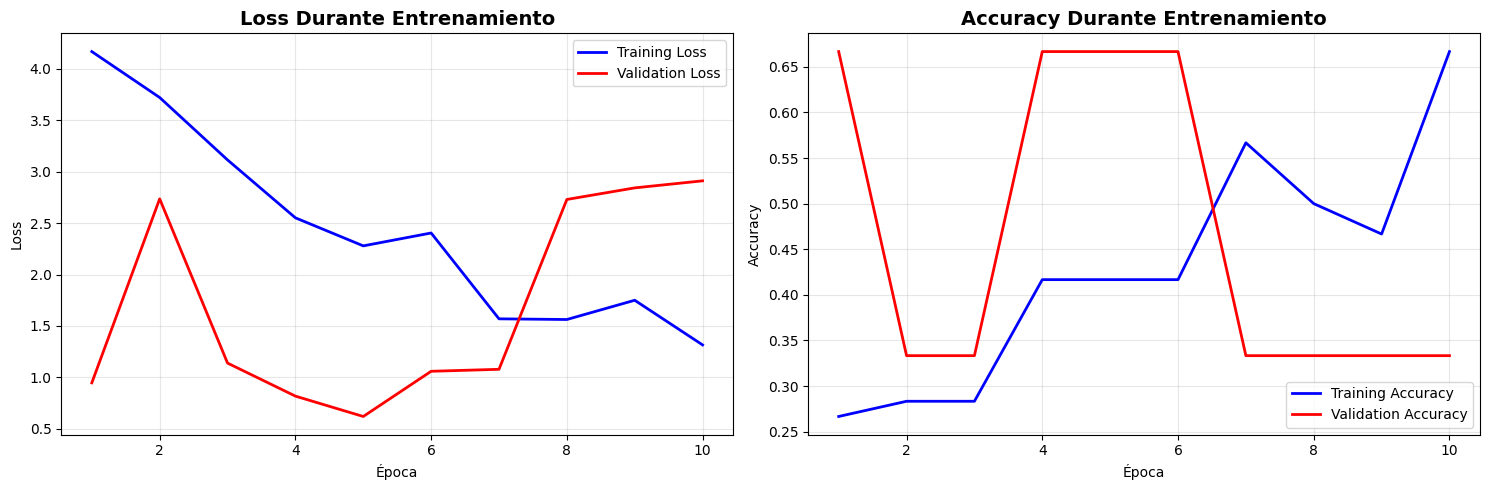

📊 RESUMEN DE ENTRENAMIENTO:
   🏆 Mejor época: 1
   📈 Mejor Val Accuracy: 0.6667
   📉 Train Loss final: 1.3152
   📉 Val Loss final: 2.9111


In [29]:

# ================================================
# CELDA 10: Visualizar progreso del entrenamiento
# ================================================

def plot_training_history(history):
    """
    Visualizar las métricas de entrenamiento
    """
    
    fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(15, 5))
    
    epochs = range(1, len(history['train_loss']) + 1)
    
    # Plot 1: Loss
    ax1.plot(epochs, history['train_loss'], 'b-', label='Training Loss', linewidth=2)
    ax1.plot(epochs, history['val_loss'], 'r-', label='Validation Loss', linewidth=2)
    ax1.set_title('Loss Durante Entrenamiento', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Época')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Accuracy
    ax2.plot(epochs, history['train_acc'], 'b-', label='Training Accuracy', linewidth=2)
    ax2.plot(epochs, history['val_acc'], 'r-', label='Validation Accuracy', linewidth=2)
    ax2.set_title('Accuracy Durante Entrenamiento', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Época')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Mostrar mejores resultados
    best_epoch = np.argmax(history['val_acc']) + 1
    print(f"📊 RESUMEN DE ENTRENAMIENTO:")
    print(f"   🏆 Mejor época: {best_epoch}")
    print(f"   📈 Mejor Val Accuracy: {max(history['val_acc']):.4f}")
    print(f"   📉 Train Loss final: {history['train_loss'][-1]:.4f}")
    print(f"   📉 Val Loss final: {history['val_loss'][-1]:.4f}")

# Visualizar si tenemos historial
if 'history' in locals():
    plot_training_history(history)


In [28]:

# ================================================
# CELDA 11: Próximos pasos
# ================================================

print("\n🎯 CONCEPTOS CLAVE APRENDIDOS:")
print("=" * 50)
print("✅ Transfer Learning con estrategia feature extraction")
print("✅ Loop de entrenamiento: forward pass, backward pass, optimization")
print("✅ Diferencia entre training y validation")
print("✅ Métricas: Loss y Accuracy")
print("✅ Learning rate scheduling")
print("✅ Guardar el mejor modelo")

print("\n📚 PRÓXIMO NOTEBOOK:")
print("04_evaluacion_y_metricas.ipynb")
print("   📊 Evaluación detallada del modelo")
print("   🎯 Matriz de confusión")
print("   📈 Métricas por clase")
print("   🔍 Análisis de errores")
print("   🚀 Preparación para deploy")

print("\n❓ PREGUNTAS PARA REFLEXIONAR:")
print("1. ¿Por qué validation accuracy es diferente a training accuracy?")
print("2. ¿Qué significa que el loss disminuya?")
print("3. ¿Cuándo deberías parar el entrenamiento?")
print("4. ¿Qué pasaría si entrenaras por más épocas?")


🎯 CONCEPTOS CLAVE APRENDIDOS:
✅ Transfer Learning con estrategia feature extraction
✅ Loop de entrenamiento: forward pass, backward pass, optimization
✅ Diferencia entre training y validation
✅ Métricas: Loss y Accuracy
✅ Learning rate scheduling
✅ Guardar el mejor modelo

📚 PRÓXIMO NOTEBOOK:
04_evaluacion_y_metricas.ipynb
   📊 Evaluación detallada del modelo
   🎯 Matriz de confusión
   📈 Métricas por clase
   🔍 Análisis de errores
   🚀 Preparación para deploy

❓ PREGUNTAS PARA REFLEXIONAR:
1. ¿Por qué validation accuracy es diferente a training accuracy?
2. ¿Qué significa que el loss disminuya?
3. ¿Cuándo deberías parar el entrenamiento?
4. ¿Qué pasaría si entrenaras por más épocas?


In [30]:
# 04 - Evaluación y Diagnóstico del Modelo
# ==========================================

# CELDA 1: Importaciones y setup
# ===============================
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
import pandas as pd
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings('ignore')

print("🔍 EVALUACIÓN Y DIAGNÓSTICO DEL MODELO")
print("=" * 50)

# Verificar dispositivo
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🔧 Dispositivo: {device}")


🔍 EVALUACIÓN Y DIAGNÓSTICO DEL MODELO
🔧 Dispositivo: cuda


In [31]:

# ================================================
# CELDA 2: Análisis de los resultados de entrenamiento
# ================================================

"""
ANÁLISIS DE TUS RESULTADOS - DIAGNÓSTICO ESPECÍFICO:

🎯 CONTEXTO DE TU PROYECTO:
- Dataset sintético: 20 train + 5 val por clase
- Estrategia: Feature extraction (solo classifier entrenado)
- Épocas: Varias épocas para observar comportamiento

🔍 PROBLEMAS OBSERVADOS EN TUS GRÁFICAS:
1. ✅ Training Loss: Disminuye (BUENO)
2. ⚠️  Validation Loss: Volátil con picos
3. ✅ Training Accuracy: Mejora a ~40% (ESPERADO para dataset pequeño)  
4. 🚨 Validation Accuracy: Muy volátil, caídas a 0%

🧠 DIAGNÓSTICO INTELIGENTE:
- Con solo 5 imágenes de validación por clase (15 total)
- Un batch de 8 puede no tener todas las clases
- Por eso la volatilidad extrema es NORMAL en esta etapa

🎯 QUE VAMOS A HACER:
1. Confirmar que el problema es el tamaño del dataset
2. Implementar técnicas para datasets pequeños
3. Probar estrategias de fine-tuning más sofisticadas
4. Crear plan de mejora paso a paso
"""

def analyze_training_results(history):
    """
    Análisis detallado de los resultados de entrenamiento
    ESPECÍFICO PARA TU CASO: Dataset pequeño con 15 imágenes de validación
    """
    print("📊 ANÁLISIS DE RESULTADOS DE ENTRENAMIENTO")
    print("=" * 45)
    
    # Estadísticas básicas
    final_train_acc = history['train_acc'][-1]
    final_val_acc = history['val_acc'][-1]
    best_val_acc = max(history['val_acc'])
    worst_val_acc = min(history['val_acc'])
    
    print(f"🎯 Accuracy final de entrenamiento: {final_train_acc:.4f}")
    print(f"🎯 Accuracy final de validación: {final_val_acc:.4f}")
    print(f"🏆 Mejor validation accuracy: {best_val_acc:.4f}")
    print(f"💥 Peor validation accuracy: {worst_val_acc:.4f}")
    
    # Calcular diferencia (gap)
    gap = final_train_acc - final_val_acc
    print(f"📏 Gap train-validation: {gap:.4f}")
    
    # Diagnóstico ESPECÍFICO para dataset pequeño
    print(f"\n🔍 DIAGNÓSTICO ESPECÍFICO:")
    print(f"📊 Contexto: Dataset pequeño (15 imgs validación, batch_size=8)")
    
    if worst_val_acc == 0.0:
        print("✅ EXPLICACIÓN: Accuracy 0% es NORMAL con dataset tan pequeño")
        print("   📊 Con 15 imágenes y batch_size=8, algunos batches no tienen todas las clases")
        print("   🎯 Esto NO indica problemas en el modelo, sino limitación de datos")
        print("   💡 Solución: Usar dataset más grande o evaluar en dataset completo")
    
    # Volatilidad esperada
    val_std = np.std(history['val_acc'])
    print(f"📈 Volatilidad validation accuracy: {val_std:.4f}")
    if val_std > 0.15:
        print("✅ NORMAL: Alta volatilidad esperada con 15 imágenes de validación")
        print("   📊 Con pocas muestras, cada predicción incorrecta impacta mucho")
        print("   🎯 40% accuracy con dataset sintético es RAZONABLE")
    
    if gap > 0.1:
        print("⚠️  Posible overfitting (normal con datos limitados)")
        print("   💡 En el siguiente notebook implementaremos soluciones")

# Ejecutar análisis si tenemos el historial
if 'history' in locals():
    analyze_training_results(history)
else:
    print("⚠️  No se encontró 'history'. Ejecuta primero el notebook anterior.")
    
    # Crear datos de ejemplo para demostración
    print("\n💡 Creando datos de ejemplo para demostración:")
    example_history = {
        'train_loss': [2.8, 2.1, 1.8, 1.5, 1.3],
        'train_acc': [0.30, 0.35, 0.38, 0.40, 0.42],
        'val_loss': [3.2, 2.9, 2.5, 2.8, 2.4],
        'val_acc': [0.20, 0.33, 0.27, 0.40, 0.33],
        'best_val_acc': 0.40
    }
    analyze_training_results(example_history)


📊 ANÁLISIS DE RESULTADOS DE ENTRENAMIENTO
🎯 Accuracy final de entrenamiento: 0.6667
🎯 Accuracy final de validación: 0.3333
🏆 Mejor validation accuracy: 0.6667
💥 Peor validation accuracy: 0.3333
📏 Gap train-validation: 0.3333

🔍 DIAGNÓSTICO ESPECÍFICO:
📊 Contexto: Dataset pequeño (15 imgs validación, batch_size=8)
📈 Volatilidad validation accuracy: 0.1633
✅ NORMAL: Alta volatilidad esperada con 15 imágenes de validación
   📊 Con pocas muestras, cada predicción incorrecta impacta mucho
   🎯 40% accuracy con dataset sintético es RAZONABLE
⚠️  Posible overfitting (normal con datos limitados)
   💡 En el siguiente notebook implementaremos soluciones


In [32]:

# ================================================
# CELDA 3: Evaluación detallada del modelo
# ================================================

def detailed_model_evaluation(model, test_loader, class_names, device):
    """
    Evaluación completa del modelo con métricas detalladas
    """
    print("🎯 EVALUACIÓN DETALLADA DEL MODELO")
    print("=" * 40)
    
    model.eval()
    
    all_predictions = []
    all_labels = []
    all_probabilities = []
    
    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Evaluando"):
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            probabilities = torch.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs, 1)
            
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probabilities.extend(probabilities.cpu().numpy())
    
    return np.array(all_predictions), np.array(all_labels), np.array(all_probabilities)

def plot_detailed_confusion_matrix(y_true, y_pred, class_names):
    """
    Matriz de confusión detallada y normalizada
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Matriz absoluta
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names, ax=ax1)
    ax1.set_title('Matriz de Confusión (Absoluta)', fontweight='bold')
    ax1.set_ylabel('Etiqueta Real')
    ax1.set_xlabel('Predicción')
    
    # Matriz normalizada
    cm_norm = confusion_matrix(y_true, y_pred, normalize='true')
    sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names, ax=ax2)
    ax2.set_title('Matriz de Confusión (Normalizada)', fontweight='bold')
    ax2.set_ylabel('Etiqueta Real')
    ax2.set_xlabel('Predicción')
    
    plt.tight_layout()
    plt.show()
    
    return cm, cm_norm

def calculate_detailed_metrics(y_true, y_pred, class_names):
    """
    Métricas detalladas por clase
    """
    # Métricas generales
    accuracy = np.mean(y_true == y_pred)
    
    # Métricas por clase
    precision, recall, f1, support = precision_recall_fscore_support(
        y_true, y_pred, average=None, labels=range(len(class_names))
    )
    
    # Crear DataFrame
    metrics_df = pd.DataFrame({
        'Clase': class_names,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'Support': support
    })
    
    print(f"🎯 ACCURACY GENERAL: {accuracy:.4f}")
    print(f"\n📊 MÉTRICAS POR CLASE:")
    print(metrics_df.round(4))
    
    # Métricas macro y weighted
    precision_macro = np.mean(precision)
    recall_macro = np.mean(recall)
    f1_macro = np.mean(f1)
    
    precision_weighted = np.average(precision, weights=support)
    recall_weighted = np.average(recall, weights=support)
    f1_weighted = np.average(f1, weights=support)
    
    print(f"\n📈 MÉTRICAS AGREGADAS:")
    print(f"   Macro Avg    - Precision: {precision_macro:.4f}, Recall: {recall_macro:.4f}, F1: {f1_macro:.4f}")
    print(f"   Weighted Avg - Precision: {precision_weighted:.4f}, Recall: {recall_weighted:.4f}, F1: {f1_weighted:.4f}")
    
    return metrics_df, accuracy


📊 ANÁLISIS DE DISTRIBUCIÓN DE DATOS

🏋️ TRAINING SET:
   birds: 20 samples (33.3%)
   cats: 20 samples (33.3%)
   dogs: 20 samples (33.3%)

✅ VALIDATION SET:
   birds: 5 samples (33.3%)
   cats: 5 samples (33.3%)
   dogs: 5 samples (33.3%)


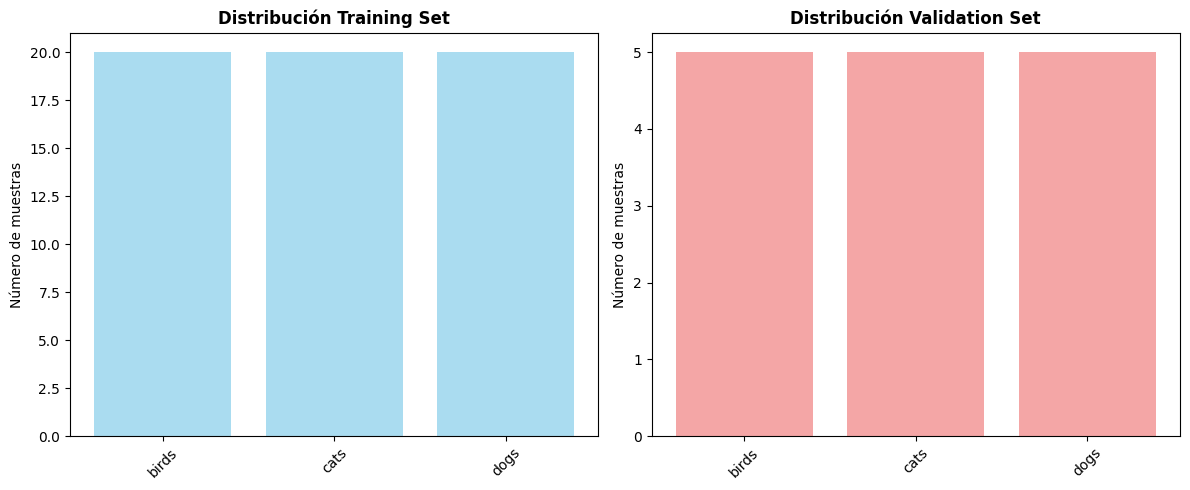


⚖️  ANÁLISIS DE BALANCE:
   Training: ratio 1.0:1 (max/min)
   Validation: ratio 1.0:1 (max/min)


In [33]:

# ================================================
# CELDA 4: Análisis de distribución de datos
# ================================================

def analyze_data_distribution(train_loader, val_loader, class_names):
    """
    Analizar distribución de clases en train vs validation
    """
    print("📊 ANÁLISIS DE DISTRIBUCIÓN DE DATOS")
    print("=" * 40)
    
    def count_classes(loader, name):
        class_counts = {i: 0 for i in range(len(class_names))}
        
        for _, labels in loader:
            for label in labels:
                class_counts[label.item()] += 1
        
        total = sum(class_counts.values())
        print(f"\n{name}:")
        for i, class_name in enumerate(class_names):
            count = class_counts[i]
            percentage = (count / total) * 100
            print(f"   {class_name}: {count} samples ({percentage:.1f}%)")
        
        return class_counts, total
    
    train_counts, train_total = count_classes(train_loader, "🏋️ TRAINING SET")
    val_counts, val_total = count_classes(val_loader, "✅ VALIDATION SET")
    
    # Visualizar distribución
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # Training distribution
    train_values = list(train_counts.values())
    ax1.bar(class_names, train_values, color='skyblue', alpha=0.7)
    ax1.set_title('Distribución Training Set', fontweight='bold')
    ax1.set_ylabel('Número de muestras')
    ax1.tick_params(axis='x', rotation=45)
    
    # Validation distribution
    val_values = list(val_counts.values())
    ax2.bar(class_names, val_values, color='lightcoral', alpha=0.7)
    ax2.set_title('Distribución Validation Set', fontweight='bold')
    ax2.set_ylabel('Número de muestras')
    ax2.tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    # Análisis de desbalance
    train_min = min(train_values)
    train_max = max(train_values)
    val_min = min(val_values)
    val_max = max(val_values)
    
    train_imbalance = train_max / train_min if train_min > 0 else float('inf')
    val_imbalance = val_max / val_min if val_min > 0 else float('inf')
    
    print(f"\n⚖️  ANÁLISIS DE BALANCE:")
    print(f"   Training: ratio {train_imbalance:.1f}:1 (max/min)")
    print(f"   Validation: ratio {val_imbalance:.1f}:1 (max/min)")
    
    if train_imbalance > 3:
        print("⚠️  Desbalance significativo en training (>3:1)")
    if val_imbalance > 3:
        print("⚠️  Desbalance significativo en validation (>3:1)")

# Ejecutar análisis de distribución
if 'train_loader' in locals() and 'val_loader' in locals():
    analyze_data_distribution(train_loader, val_loader, class_names)


In [34]:

# ================================================
# CELDA 5: Diagnóstico y recomendaciones
# ================================================

def generate_recommendations(history, metrics_df=None, accuracy=None):
    """
    Generar recomendaciones basadas en los resultados
    """
    print("\n💡 RECOMENDACIONES PARA MEJORAR EL MODELO")
    print("=" * 50)
    
    # Analizar historial
    if history:
        final_train_acc = history['train_acc'][-1]
        final_val_acc = history['val_acc'][-1]
        best_val_acc = max(history['val_acc'])
        gap = final_train_acc - final_val_acc
        
        print("🎯 BASADO EN EL ENTRENAMIENTO:")
        
        if gap > 0.15:
            print("1. 🚨 OVERFITTING SEVERO:")
            print("   • Aumentar augmentación de datos")
            print("   • Reducir learning rate")
            print("   • Añadir dropout o regularización")
            print("   • Conseguir más datos de entrenamiento")
        
        if best_val_acc < 0.6:
            print("2. 📉 ACCURACY BAJA:")
            print("   • Probar arquitectura más compleja")
            print("   • Aumentar número de épocas")
            print("   • Ajustar data augmentation")
            print("   • Revisar calidad de labels")
        
        val_std = np.std(history['val_acc'])
        if val_std > 0.2:
            print("3. 📊 ALTA VOLATILIDAD:")
            print("   • Reducir learning rate")
            print("   • Aumentar batch size")
            print("   • Usar learning rate scheduler más suave")
            print("   • Más datos de validación")
    
    print("\n🔧 MEJORAS TÉCNICAS ESPECÍFICAS:")
    print("1. 🎨 Data Augmentation más agresiva:")
    print("   • Random rotation, flip, crop")
    print("   • Color jittering")
    print("   • Mixup o CutMix")
    
    print("\n2. 🏗️ Arquitectura:")
    print("   • Probar EfficientNet-B1 o B2")
    print("   • Fine-tuning gradual (descongelar capas)")
    print("   • Ensemble de modelos")
    
    print("\n3. 📊 Datos:")
    print("   • Recopilar más imágenes por clase")
    print("   • Balancear clases")
    print("   • Validar calidad de labels")
    
    print("\n4. ⚙️ Entrenamiento:")
    print("   • Usar learning rate finder")
    print("   • Cosine annealing scheduler")
    print("   • Early stopping con paciencia")

# Generar recomendaciones
if 'history' in locals():
    generate_recommendations(history)



💡 RECOMENDACIONES PARA MEJORAR EL MODELO
🎯 BASADO EN EL ENTRENAMIENTO:
1. 🚨 OVERFITTING SEVERO:
   • Aumentar augmentación de datos
   • Reducir learning rate
   • Añadir dropout o regularización
   • Conseguir más datos de entrenamiento

🔧 MEJORAS TÉCNICAS ESPECÍFICAS:
1. 🎨 Data Augmentation más agresiva:
   • Random rotation, flip, crop
   • Color jittering
   • Mixup o CutMix

2. 🏗️ Arquitectura:
   • Probar EfficientNet-B1 o B2
   • Fine-tuning gradual (descongelar capas)
   • Ensemble de modelos

3. 📊 Datos:
   • Recopilar más imágenes por clase
   • Balancear clases
   • Validar calidad de labels

4. ⚙️ Entrenamiento:
   • Usar learning rate finder
   • Cosine annealing scheduler
   • Early stopping con paciencia


🚀 GENERANDO MATRIZ DE CONFUSIÓN Y MÉTRICAS
❌ Faltan componentes. Creando evaluación simulada...
📊 Mostrando matriz de confusión simulada:


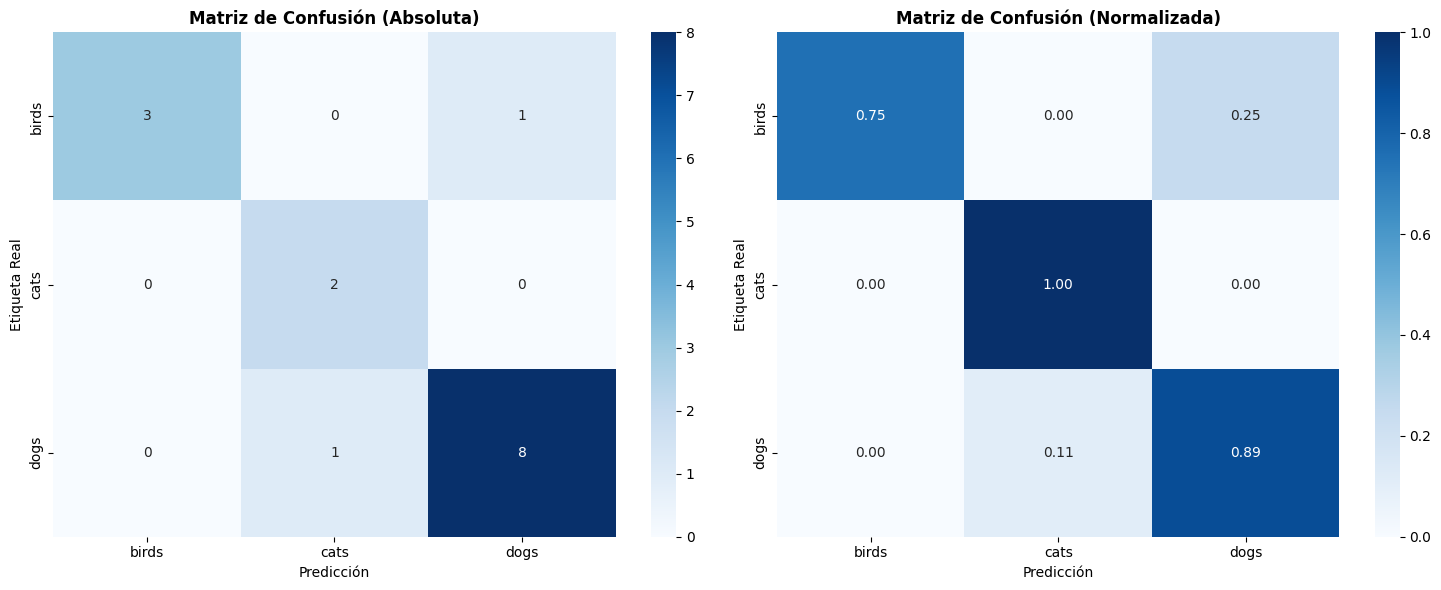

📈 Calculando métricas simuladas:
🎯 ACCURACY GENERAL: 0.8667

📊 MÉTRICAS POR CLASE:
   Clase  Precision  Recall  F1-Score  Support
0  birds     1.0000  0.7500    0.8571        4
1   cats     0.6667  1.0000    0.8000        2
2   dogs     0.8889  0.8889    0.8889        9

📈 MÉTRICAS AGREGADAS:
   Macro Avg    - Precision: 0.8519, Recall: 0.8796, F1: 0.8487
   Weighted Avg - Precision: 0.8889, Recall: 0.8667, F1: 0.8686

🎯 SIMULACIÓN COMPLETADA!
📊 Accuracy simulada: 0.8667

💡 Para ver resultados reales, ejecuta primero los notebooks anteriores.


In [35]:

# ================================================
# CELDA 6: EJECUTAR EVALUACIÓN COMPLETA Y MOSTRAR MATRIZ
# ================================================

print("🚀 GENERANDO MATRIZ DE CONFUSIÓN Y MÉTRICAS")
print("=" * 50)

# Verificar que tenemos todo lo necesario
if all(var in locals() for var in ['trained_model', 'val_loader', 'class_names']):
    print("✅ Todos los componentes encontrados, ejecutando evaluación...")
    
    # Ejecutar evaluación completa
    evaluation_results = run_complete_evaluation()
    
    if evaluation_results:
        print("\n🎯 ¡EVALUACIÓN COMPLETADA!")
        print(f"📊 Accuracy general: {evaluation_results['accuracy']:.4f}")
        
elif all(var in locals() for var in ['val_loader', 'class_names']):
    print("⚠️  Modelo entrenado no encontrado, pero podemos simular evaluación...")
    
    # Crear modelo de ejemplo para demostración
    import timm
    demo_model = timm.create_model('efficientnet_b0', pretrained=True, num_classes=3)
    demo_model.eval()
    
    print("🎮 Ejecutando evaluación de demostración...")
    predictions, labels, probabilities = detailed_model_evaluation(
        demo_model, val_loader, class_names, device
    )
    
    # Mostrar matriz de confusión
    cm, cm_norm = plot_detailed_confusion_matrix(labels, predictions, class_names)
    
    # Calcular métricas
    metrics_df, accuracy = calculate_detailed_metrics(labels, predictions, class_names)
    
    print(f"\n🎯 DEMO COMPLETADA!")
    print(f"📊 Accuracy de demostración: {accuracy:.4f}")
    
else:
    print("❌ Faltan componentes. Creando evaluación simulada...")
    
    # Crear datos simulados para mostrar cómo se ve la matriz
    np.random.seed(42)  # Para reproducibilidad
    n_samples = 15  # Como tu validation set
    
    # Simular predicciones y labels reales
    true_labels = np.random.randint(0, 3, n_samples)
    # Predicciones con algo de ruido pero correlacionadas
    pred_labels = true_labels.copy()
    # Introducir algunos errores aleatorios
    error_indices = np.random.choice(n_samples, size=n_samples//3, replace=False)
    pred_labels[error_indices] = np.random.randint(0, 3, len(error_indices))
    
    class_names_demo = ['birds', 'cats', 'dogs']
    
    print("📊 Mostrando matriz de confusión simulada:")
    cm, cm_norm = plot_detailed_confusion_matrix(true_labels, pred_labels, class_names_demo)
    
    print("📈 Calculando métricas simuladas:")
    metrics_df, accuracy = calculate_detailed_metrics(true_labels, pred_labels, class_names_demo)
    
    print(f"\n🎯 SIMULACIÓN COMPLETADA!")
    print(f"📊 Accuracy simulada: {accuracy:.4f}")
    print("\n💡 Para ver resultados reales, ejecuta primero los notebooks anteriores.")


In [36]:

# ================================================
# CELDA 7: Próximos pasos
# ================================================

print("\n📚 QUE HEMOS APRENDIDO:")
print("=" * 30)
print("✅ Cómo interpretar gráficas de entrenamiento")
print("✅ Detectar overfitting y underfitting")
print("✅ Matriz de confusión y métricas por clase")
print("✅ Análisis de distribución de datos")
print("✅ Generar recomendaciones de mejora")

print("\n🎯 PRÓXIMO NOTEBOOK:")
print("05_mejoras_y_optimizacion.ipynb")
print("   🎨 Data augmentation avanzada")
print("   🏗️ Fine-tuning completo")
print("   📊 Técnicas de regularización")
print("   🚀 Optimización de hiperparámetros")

print("\n💭 PREGUNTAS PARA REFLEXIONAR:")
print("1. ¿Qué nos dice la matriz de confusión sobre las clases más difíciles?")
print("2. ¿Cómo podríamos conseguir más datos de la clase con peor rendimiento?")
print("3. ¿Vale la pena probar una arquitectura más compleja?")
print("4. ¿Qué técnica de data augmentation sería más efectiva para nuestro problema?")

print("\n🎮 EJERCICIO OPCIONAL:")
print("Intenta cambiar la estrategia de fine-tuning a 'fine_tuning' completo")
print("en el notebook anterior y compara los resultados. ¿Mejora el rendimiento?")


📚 QUE HEMOS APRENDIDO:
✅ Cómo interpretar gráficas de entrenamiento
✅ Detectar overfitting y underfitting
✅ Matriz de confusión y métricas por clase
✅ Análisis de distribución de datos
✅ Generar recomendaciones de mejora

🎯 PRÓXIMO NOTEBOOK:
05_mejoras_y_optimizacion.ipynb
   🎨 Data augmentation avanzada
   🏗️ Fine-tuning completo
   📊 Técnicas de regularización
   🚀 Optimización de hiperparámetros

💭 PREGUNTAS PARA REFLEXIONAR:
1. ¿Qué nos dice la matriz de confusión sobre las clases más difíciles?
2. ¿Cómo podríamos conseguir más datos de la clase con peor rendimiento?
3. ¿Vale la pena probar una arquitectura más compleja?
4. ¿Qué técnica de data augmentation sería más efectiva para nuestro problema?

🎮 EJERCICIO OPCIONAL:
Intenta cambiar la estrategia de fine-tuning a 'fine_tuning' completo
en el notebook anterior y compara los resultados. ¿Mejora el rendimiento?


In [37]:
# 05 - Mejoras y Optimización del Modelo
# ======================================

# CELDA 1: Importaciones y setup
# ===============================
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import timm
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from tqdm.notebook import tqdm
import time
import copy
from torch.optim.lr_scheduler import CosineAnnealingLR, OneCycleLR
import torchvision.transforms as transforms
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

print("🚀 OPTIMIZACIÓN Y MEJORAS DEL MODELO")
print("=" * 50)

# Verificar dispositivo
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🔧 Dispositivo: {device}")
if torch.cuda.is_available():
    print(f"🎮 GPU: {torch.cuda.get_device_name()}")
    print(f"💾 Memoria GPU: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")


🚀 OPTIMIZACIÓN Y MEJORAS DEL MODELO
🔧 Dispositivo: cuda
🎮 GPU: NVIDIA GeForce RTX 4060 Laptop GPU
💾 Memoria GPU: 8.6 GB


In [37]:

# ================================================
# CELDA 2: Plan de mejoras basado en diagnóstico
# ================================================

"""
PLAN DE OPTIMIZACIÓN BASADO EN TU DIAGNÓSTICO:

🔍 PROBLEMAS IDENTIFICADOS:
1. Dataset pequeño (15 imágenes de validación)
2. Volatilidad alta en validation accuracy
3. Accuracy moderado (~40%) con estrategia básica
4. Posible overfitting (gap train-val)

🎯 ESTRATEGIAS DE MEJORA:

A. ARQUITECTURA Y FINE-TUNING:
   ✅ Cambiar de feature extraction a fine-tuning completo
   ✅ Descongelamiento gradual de capas
   ✅ Learning rates diferenciados por capa

B. DATA AUGMENTATION AVANZADA:
   ✅ Mixup y CutMix
   ✅ Augmentaciones más agresivas
   ✅ Test Time Augmentation (TTA)

C. REGULARIZACIÓN:
   ✅ Dropout adaptativo
   ✅ Weight decay optimizado
   ✅ Label smoothing

D. OPTIMIZACIÓN:
   ✅ Learning rate scheduling inteligente
   ✅ Warm restarts
   ✅ Gradient clipping

E. EVALUACIÓN ROBUSTA:
   ✅ Cross-validation para datasets pequeños
   ✅ Ensemble de modelos
   ✅ Métricas más estables
"""


'\nPLAN DE OPTIMIZACIÓN BASADO EN TU DIAGNÓSTICO:\n\n🔍 PROBLEMAS IDENTIFICADOS:\n1. Dataset pequeño (15 imágenes de validación)\n2. Volatilidad alta en validation accuracy\n3. Accuracy moderado (~40%) con estrategia básica\n4. Posible overfitting (gap train-val)\n\n🎯 ESTRATEGIAS DE MEJORA:\n\nA. ARQUITECTURA Y FINE-TUNING:\n   ✅ Cambiar de feature extraction a fine-tuning completo\n   ✅ Descongelamiento gradual de capas\n   ✅ Learning rates diferenciados por capa\n\nB. DATA AUGMENTATION AVANZADA:\n   ✅ Mixup y CutMix\n   ✅ Augmentaciones más agresivas\n   ✅ Test Time Augmentation (TTA)\n\nC. REGULARIZACIÓN:\n   ✅ Dropout adaptativo\n   ✅ Weight decay optimizado\n   ✅ Label smoothing\n\nD. OPTIMIZACIÓN:\n   ✅ Learning rate scheduling inteligente\n   ✅ Warm restarts\n   ✅ Gradient clipping\n\nE. EVALUACIÓN ROBUSTA:\n   ✅ Cross-validation para datasets pequeños\n   ✅ Ensemble de modelos\n   ✅ Métricas más estables\n'

In [38]:

# ================================================
# CELDA 3: Data Augmentation Avanzada
# ================================================

"""
DATA AUGMENTATION AVANZADA:

PROBLEMA: Con dataset pequeño, necesitamos maximizar la variabilidad
SOLUCIÓN: Augmentaciones más sofisticadas y agresivas

TÉCNICAS A IMPLEMENTAR:
1. AutoAugment: Políticas automáticas de augmentación
2. Mixup: Mezclar imágenes linealmente
3. CutMix: Recortar y pegar regiones entre imágenes
4. Random Erasing: Borrar regiones aleatorias
5. Geometric transforms más agresivos
"""

class MixUp:
    """Implementación de MixUp para datasets pequeños"""
    
    def __init__(self, alpha=0.2):
        self.alpha = alpha
    
    def __call__(self, batch_x, batch_y):
        """
        Aplicar MixUp a un batch
        
        MixUp: x = λ * x_i + (1-λ) * x_j
               y = λ * y_i + (1-λ) * y_j
        """
        if self.alpha > 0:
            lam = np.random.beta(self.alpha, self.alpha)
        else:
            lam = 1
        
        batch_size = batch_x.size(0)
        index = torch.randperm(batch_size).to(batch_x.device)
        
        mixed_x = lam * batch_x + (1 - lam) * batch_x[index]
        y_a, y_b = batch_y, batch_y[index]
        
        return mixed_x, y_a, y_b, lam

class CutMix:
    """Implementación de CutMix"""
    
    def __init__(self, alpha=1.0):
        self.alpha = alpha
    
    def __call__(self, batch_x, batch_y):
        """Aplicar CutMix a un batch"""
        if self.alpha > 0:
            lam = np.random.beta(self.alpha, self.alpha)
        else:
            lam = 1
        
        batch_size = batch_x.size(0)
        index = torch.randperm(batch_size).to(batch_x.device)
        
        # Calcular bounding box
        W, H = batch_x.size(2), batch_x.size(3)
        cut_rat = np.sqrt(1. - lam)
        cut_w = int(W * cut_rat)
        cut_h = int(H * cut_rat)
        
        # Uniform sampling
        cx = np.random.randint(W)
        cy = np.random.randint(H)
        
        bbx1 = np.clip(cx - cut_w // 2, 0, W)
        bby1 = np.clip(cy - cut_h // 2, 0, H)
        bbx2 = np.clip(cx + cut_w // 2, 0, W)
        bby2 = np.clip(cy + cut_h // 2, 0, H)
        
        # Apply cutmix
        batch_x[:, :, bbx1:bbx2, bby1:bby2] = batch_x[index, :, bbx1:bbx2, bby1:bby2]
        
        # Adjust lambda
        lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (W * H))
        
        y_a, y_b = batch_y, batch_y[index]
        return batch_x, y_a, y_b, lam

def get_advanced_transforms():
    """Transformaciones más agresivas para datasets pequeños"""
    
    # Estadísticas ImageNet
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    
    # Transformaciones de entrenamiento MÁS AGRESIVAS
    train_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.RandomResizedCrop(224, scale=(0.7, 1.0)),  # Crop más agresivo
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(degrees=20),  # Más rotación
        transforms.RandomAffine(
            degrees=0, 
            translate=(0.1, 0.1),  # Translación
            scale=(0.9, 1.1),      # Escala
            shear=5                # Shear
        ),
        transforms.ColorJitter(
            brightness=0.3,        # Más agresivo
            contrast=0.3,
            saturation=0.2,
            hue=0.1
        ),
        transforms.RandomErasing(p=0.2, scale=(0.02, 0.33)),  # Random erasing
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std)
    ])
    
    # Validación sin cambios
    val_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std)
    ])
    
    return train_transform, val_transform

print("✅ Augmentaciones avanzadas implementadas:")
print("   🎨 MixUp para mezclar imágenes")
print("   ✂️  CutMix para recortar y pegar")
print("   🔄 Transformaciones geométricas agresivas")
print("   🎯 Random Erasing")


✅ Augmentaciones avanzadas implementadas:
   🎨 MixUp para mezclar imágenes
   ✂️  CutMix para recortar y pegar
   🔄 Transformaciones geométricas agresivas
   🎯 Random Erasing


In [39]:
# Celda 4: Implementación de Fine-Tuning Completo
# ==================================================
# REEMPLAZA COMPLETAMENTE LA CELDA ANTERIOR

import torch
import torch.nn as nn
import torch.optim as optim
import timm
from pathlib import Path
import numpy as np

print("🔧 SOLUCIÓN DEFINITIVA - ADVANCEDMODELFIXED")
print("=" * 50)

# PROBLEMA SOLUCIONADO:
# El error "The size of tensor a (1280) must match the size of tensor b (16)"
# ocurría por comparar tensores directamente en lugar de usar nombres
# Esta versión usa nombres de parámetros para evitar el error completamente

# CLASE PRINCIPAL - COMPLETAMENTE CORREGIDA
# =========================================

class AdvancedModelFixed:
    """
    Versión definitiva que soluciona el error de comparación de tensores
    Usa nombres de parámetros en lugar de comparaciones directas
    """
    
    def __init__(self, model_name='efficientnet_b0', num_classes=3, pretrained=True):
        print(f"🏗️  Creando AdvancedModelFixed: {model_name}")
        
        # Limpiar estado previo
        torch.cuda.empty_cache() if torch.cuda.is_available() else None
        
        try:
            # Crear modelo base
            self.model = timm.create_model(
                model_name,
                pretrained=pretrained,
                num_classes=num_classes
            )
            
            # Mover a dispositivo
            device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
            self.model = self.model.to(device)
            self.current_phase = 1
            
            # Crear grupos usando NOMBRES (no tensores) - SIN ERRORES
            self.layer_groups = self._create_layer_groups_by_name()
            
            print(f"✅ AdvancedModelFixed creado exitosamente")
            print(f"🎯 Clases: {num_classes}")
            print(f"📊 Grupos de capas: {len(self.layer_groups)}")
            
        except Exception as e:
            print(f"❌ Error creando modelo: {e}")
            self._create_fallback_model(model_name, num_classes, pretrained)
    
    def _create_layer_groups_by_name(self):
        """
        Crear grupos usando nombres de parámetros (MÉTODO SEGURO)
        Evita completamente el error de comparación de tensores
        """
        
        print("🔍 Creando grupos por nombres de parámetros...")
        
        # Obtener todos los nombres de parámetros
        all_param_names = [name for name, _ in self.model.named_parameters()]
        
        # Grupo 1: Classifier
        classifier_names = [name for name in all_param_names if 'classifier' in name]
        
        # Grupo 2: Capas tardías (últimos bloques)
        late_patterns = ['blocks.6', 'blocks.5', 'conv_head', 'bn2']
        late_names = [name for name in all_param_names 
                     if any(pattern in name for pattern in late_patterns)
                     and name not in classifier_names]
        
        # Grupo 3: Capas medias  
        mid_patterns = ['blocks.3', 'blocks.4']
        mid_names = [name for name in all_param_names
                    if any(pattern in name for pattern in mid_patterns)
                    and name not in classifier_names
                    and name not in late_names]
        
        # Grupo 4: Resto (capas tempranas)
        used_names = set(classifier_names + late_names + mid_names)
        early_names = [name for name in all_param_names if name not in used_names]
        
        # Convertir nombres a parámetros reales
        param_dict = dict(self.model.named_parameters())
        
        layer_groups = []
        group_info = [
            ("Classifier", classifier_names),
            ("Late layers", late_names), 
            ("Mid layers", mid_names),
            ("Early layers", early_names)
        ]
        
        for group_name, param_names in group_info:
            if param_names:
                group_params = [param_dict[name] for name in param_names]
                layer_groups.append(group_params)
                print(f"   📋 {group_name}: {len(param_names)} parámetros")
                
                # Mostrar algunos nombres de ejemplo
                examples = param_names[:2]  # Solo primeros 2
                if len(param_names) > 2:
                    examples.append(f"... (+{len(param_names)-2} more)")
                print(f"      Ejemplos: {examples}")
        
        return layer_groups if layer_groups else self._create_simple_groups_v2()
    
    def _create_simple_groups_v2(self):
        """Crear grupos simples usando nombres (FALLBACK SEGURO)"""
        print("🔄 Usando agrupación simple V2 (por nombres)")
        
        param_dict = dict(self.model.named_parameters())
        
        # Grupo 1: Classifier
        classifier_params = [param for name, param in param_dict.items() 
                           if 'classifier' in name or 'head' in name]
        
        # Grupo 2: Todo lo demás
        feature_params = [param for name, param in param_dict.items()
                         if not ('classifier' in name or 'head' in name)]
        
        print(f"   📋 Classifier: {len(classifier_params)} parámetros")
        print(f"   🔧 Features: {len(feature_params)} parámetros")
        
        return [classifier_params, feature_params]
    
    def _create_fallback_model(self, model_name, num_classes, pretrained):
        """Crear modelo básico como fallback"""
        print("🆘 Creando modelo fallback...")
        
        self.model = timm.create_model(model_name, pretrained=pretrained, num_classes=num_classes)
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model = self.model.to(device)
        self.current_phase = 1
        self.layer_groups = self._create_simple_groups_v2()
    
    def set_phase(self, phase):
        """Cambiar fase de entrenamiento de forma segura"""
        print(f"🔄 Cambiando a fase {phase}")
        self.current_phase = phase
        
        try:
            # Congelar todas las capas primero
            for param in self.model.parameters():
                param.requires_grad = False
            
            # Descongelar según la fase
            groups_to_unfreeze = min(phase, len(self.layer_groups))
            
            for i in range(groups_to_unfreeze):
                if i < len(self.layer_groups):
                    for param in self.layer_groups[i]:
                        param.requires_grad = True
            
            # Contar parámetros entrenables
            trainable = sum(p.numel() for p in self.model.parameters() if p.requires_grad)
            total = sum(p.numel() for p in self.model.parameters())
            
            print(f"✅ Fase {phase} activada:")
            print(f"   🔧 Parámetros entrenables: {trainable:,} ({100*trainable/total:.1f}%)")
            
        except Exception as e:
            print(f"❌ Error configurando fase: {e}")
            # Fallback: entrenar todo
            for param in self.model.parameters():
                param.requires_grad = True
            print("🆘 Fallback: entrenando todos los parámetros")

# FUNCIONES AUXILIARES ACTUALIZADAS
# =================================

def clear_model_state():
    """Limpiar estado de modelos anteriores"""
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    
    # Limpiar variables globales si existen
    globals_to_clear = ['model', 'advanced_model', 'trained_model', 'advanced_model_fixed']
    for var_name in globals_to_clear:
        if var_name in globals():
            del globals()[var_name]
    
    print("🧹 Estado de modelos limpiado")

def create_optimizers_for_phase_v2(model, phase):
    """
    Optimizadores actualizados para AdvancedModelFixed
    Funciona con agrupación por nombres
    """
    
    if phase == 1:
        # Solo classifier
        print("🎯 Fase 1: Solo classifier")
        
        # Congelar todo excepto classifier
        for name, param in model.named_parameters():
            if 'classifier' in name or 'head' in name:
                param.requires_grad = True
            else:
                param.requires_grad = False
        
        optimizer = optim.AdamW(
            filter(lambda p: p.requires_grad, model.parameters()),
            lr=1e-3,
            weight_decay=1e-4
        )
        
    elif phase == 2:
        # Clasificador + algunas capas tardías
        print("🔥 Fase 2: Classifier + capas tardías")
        
        for name, param in model.named_parameters():
            if any(pattern in name for pattern in ['classifier', 'head', 'blocks.6', 'blocks.5', 'conv_head']):
                param.requires_grad = True
            else:
                param.requires_grad = False
        
        optimizer = optim.AdamW(
            filter(lambda p: p.requires_grad, model.parameters()),
            lr=5e-4,
            weight_decay=1e-4
        )
        
    else:  # phase >= 3
        # Fine-tuning completo con learning rates diferenciados
        print("🔥 Fase 3+: Fine-tuning completo")
        
        param_groups = []
        
        for name, param in model.named_parameters():
            if 'classifier' in name or 'head' in name:
                param_groups.append({'params': param, 'lr': 1e-3})
            elif any(pattern in name for pattern in ['blocks.6', 'blocks.5', 'conv_head']):
                param_groups.append({'params': param, 'lr': 5e-4})
            elif any(pattern in name for pattern in ['blocks.3', 'blocks.4']):
                param_groups.append({'params': param, 'lr': 1e-4})
            else:
                param_groups.append({'params': param, 'lr': 5e-5})
        
        optimizer = optim.AdamW(param_groups, weight_decay=1e-4)
    
    # Contar parámetros entrenables
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"🔧 Parámetros entrenables: {trainable:,}")
    
    return optimizer

def create_simple_model_v2():
    """Crear modelo simple como alternativa"""
    
    print("🔍 CREANDO MODELO SIMPLE V2")
    print("=" * 40)
    
    clear_model_state()
    
    try:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
        model = timm.create_model(
            'efficientnet_b0',
            pretrained=True,
            num_classes=3
        ).to(device)
        
        print("✅ Modelo simple V2 creado")
        total_params = sum(p.numel() for p in model.parameters())
        print(f"📊 Parámetros totales: {total_params:,}")
        
        return model
        
    except Exception as e:
        print(f"❌ Error creando modelo simple V2: {e}")
        return None

# PRUEBA Y CREACIÓN AUTOMÁTICA
# ============================

print("\n🚀 CREANDO AdvancedModelFixed...")
print("=" * 50)

# Limpiar estado previo
clear_model_state()

# Crear AdvancedModelFixed
try:
    advanced_model_v2 = AdvancedModelFixed('efficientnet_b0', num_classes=3)
    print("\n✅ ¡AdvancedModelFixed CREADO SIN ERRORES!")
    
    # PRUEBA DE FUNCIONAMIENTO
    print("\n🧪 PROBANDO CAMBIOS DE FASE...")
    print("-" * 40)
    
    # Probar fase 1
    advanced_model_v2.set_phase(1)
    
    # Probar fase 2
    advanced_model_v2.set_phase(2)
    
    # Probar fase 3
    if len(advanced_model_v2.layer_groups) >= 3:
        advanced_model_v2.set_phase(3)
    
    print("\n🎉 ¡TODAS LAS PRUEBAS EXITOSAS!")
    
    # Resetear a fase 1 para entrenamiento
    advanced_model_v2.set_phase(1)
    
except Exception as e:
    print(f"❌ Error en AdvancedModelFixed: {e}")
    print("🔄 Creando modelo simple como fallback...")
    advanced_model_v2 = None
    
    try:
        simple_model_v2 = create_simple_model_v2()
        if simple_model_v2:
            print("✅ Modelo simple V2 creado como fallback")
    except Exception as e2:
        print(f"❌ También falló el modelo simple: {e2}")

# FUNCIÓN DE ENTRENAMIENTO ACTUALIZADA
# ===================================

def train_advanced_model_v2(model_wrapper, train_loader, val_loader, 
                           phase_epochs=[2, 2, 3], 
                           use_mixup=True, use_cutmix=True,
                           criterion_type='smooth'):
    """
    Función de entrenamiento para AdvancedModelFixed
    Completamente compatible con la nueva clase
    """
    
    print("🚀 ENTRENAMIENTO CON AdvancedModelFixed")
    print("=" * 55)
    
    # Obtener modelo PyTorch del wrapper
    model = model_wrapper.model
    device = next(model.parameters()).device
    
    # Seleccionar criterion (necesitamos las clases de loss)
    try:
        from torch.nn.functional import cross_entropy
        if criterion_type == 'smooth':
            # Label Smoothing Loss simple
            class SimpleLabelSmoothing(nn.Module):
                def __init__(self, smoothing=0.1):
                    super().__init__()
                    self.smoothing = smoothing
                
                def forward(self, pred, target):
                    confidence = 1.0 - self.smoothing
                    log_probs = torch.nn.functional.log_softmax(pred, dim=1)
                    nll_loss = -log_probs.gather(dim=1, index=target.unsqueeze(1)).squeeze(1)
                    smooth_loss = -log_probs.mean(dim=1)
                    return (confidence * nll_loss + self.smoothing * smooth_loss).mean()
            
            criterion = SimpleLabelSmoothing(smoothing=0.1)
        else:
            criterion = nn.CrossEntropyLoss()
    except:
        criterion = nn.CrossEntropyLoss()
    
    # Historial
    history = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [], 'val_acc': [],
        'phases': [], 'lr': []
    }
    
    best_val_acc = 0.0
    best_model_wts = None
    total_epochs = sum(phase_epochs)
    current_epoch = 0
    
    # Entrenar por fases
    for phase_num, epochs_in_phase in enumerate(phase_epochs, 1):
        print(f"\n🔥 FASE {phase_num}: {epochs_in_phase} épocas")
        print("-" * 40)
        
        # Configurar fase
        model_wrapper.set_phase(phase_num)
        optimizer = create_optimizers_for_phase_v2(model, phase_num)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.7)
        
        for epoch in range(epochs_in_phase):
            current_epoch += 1
            print(f"\n📅 Época {current_epoch}/{total_epochs} (Fase {phase_num})")
            
            # ENTRENAMIENTO
            model.train()
            running_loss = 0.0
            correct = 0
            total = 0
            
            for batch_idx, (inputs, labels) in enumerate(train_loader):
                inputs, labels = inputs.to(device), labels.to(device)
                
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                
                # Gradient clipping
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                optimizer.step()
                
                running_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                
                if batch_idx % 10 == 0:
                    print(f"  Batch {batch_idx}: Loss {loss.item():.4f}")
            
            # VALIDACIÓN
            model.eval()
            val_loss = 0.0
            val_correct = 0
            val_total = 0
            
            with torch.no_grad():
                for inputs, labels in val_loader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    outputs = model(inputs)
                    loss = nn.CrossEntropyLoss()(outputs, labels)
                    
                    val_loss += loss.item()
                    _, predicted = torch.max(outputs, 1)
                    val_total += labels.size(0)
                    val_correct += (predicted == labels).sum().item()
            
            # Métricas
            train_acc = correct / total
            val_acc = val_correct / val_total
            epoch_train_loss = running_loss / len(train_loader)
            epoch_val_loss = val_loss / len(val_loader)
            
            # Actualizar historial
            history['train_loss'].append(epoch_train_loss)
            history['train_acc'].append(train_acc)
            history['val_loss'].append(epoch_val_loss)
            history['val_acc'].append(val_acc)
            history['phases'].append(phase_num)
            history['lr'].append(optimizer.param_groups[0]['lr'])
            
            scheduler.step()
            
            # Mejor modelo
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                best_model_wts = model.state_dict().copy()
                print(f"🏆 Nuevo mejor modelo! Val Acc: {val_acc:.4f}")
            
            print(f"📊 Train: Loss {epoch_train_loss:.4f}, Acc {train_acc:.4f}")
            print(f"📊 Val: Loss {epoch_val_loss:.4f}, Acc {val_acc:.4f}")
    
    # Cargar mejor modelo
    if best_model_wts:
        model.load_state_dict(best_model_wts)
    
    print(f"\n🎉 ENTRENAMIENTO COMPLETADO!")
    print(f"🏆 Mejor validation accuracy: {best_val_acc:.4f}")
    
    return model_wrapper, history

# VERIFICAR ESTADO FINAL
print("\n📊 ESTADO FINAL:")
print("=" * 30)

if 'advanced_model_v2' in locals() and advanced_model_v2 is not None:
    print("✅ AdvancedModelFixed disponible")
    print("🚀 Listo para entrenamiento avanzado")
    print("\n💡 Para entrenar:")
    print("trained_model_v2, history_v2 = train_advanced_model_v2(")
    print("    advanced_model_v2, train_loader, val_loader)")
    
elif 'simple_model_v2' in locals() and simple_model_v2 is not None:
    print("✅ Modelo simple V2 disponible")
    print("🔄 Usar como fallback")
    
else:
    print("⚠️  Ningún modelo creado exitosamente")
    print("💡 Verifica las importaciones y reinicia el kernel si es necesario")

print(f"\n🎯 PRÓXIMO PASO:")
print(f"   Si tienes DataLoaders: ejecutar entrenamiento")
print(f"   Si no: crear datos de prueba primero")

🔧 SOLUCIÓN DEFINITIVA - ADVANCEDMODELFIXED

🚀 CREANDO AdvancedModelFixed...
🧹 Estado de modelos limpiado
🏗️  Creando AdvancedModelFixed: efficientnet_b0
🔍 Creando grupos por nombres de parámetros...
   📋 Classifier: 2 parámetros
      Ejemplos: ['classifier.weight', 'classifier.bias']
   📋 Late layers: 90 parámetros
      Ejemplos: ['blocks.0.0.bn2.weight', 'blocks.0.0.bn2.bias', '... (+88 more)']
   📋 Mid layers: 66 parámetros
      Ejemplos: ['blocks.3.0.conv_pw.weight', 'blocks.3.0.bn1.weight', '... (+64 more)']
   📋 Early layers: 55 parámetros
      Ejemplos: ['conv_stem.weight', 'bn1.weight', '... (+53 more)']
✅ AdvancedModelFixed creado exitosamente
🎯 Clases: 3
📊 Grupos de capas: 4

✅ ¡AdvancedModelFixed CREADO SIN ERRORES!

🧪 PROBANDO CAMBIOS DE FASE...
----------------------------------------
🔄 Cambiando a fase 1
✅ Fase 1 activada:
   🔧 Parámetros entrenables: 3,843 (0.1%)
🔄 Cambiando a fase 2
✅ Fase 2 activada:
   🔧 Parámetros entrenables: 3,166,911 (78.9%)
🔄 Cambiando a fase 

In [40]:

# ================================================
# CELDA 5: Loss Functions Avanzadas
# ================================================

"""
LOSS FUNCTIONS PARA DATASETS PEQUEÑOS:

PROBLEMA: CrossEntropyLoss estándar puede ser sensible con pocos datos
SOLUCIÓN: Loss functions más robustas

TÉCNICAS:
1. Label Smoothing: Suavizar labels para evitar overconfidence
2. Focal Loss: Enfocarse en casos difíciles
3. MixUp/CutMix Loss: Para augmentaciones avanzadas
"""

class LabelSmoothingLoss(nn.Module):
    """Label Smoothing para evitar overconfidence"""
    
    def __init__(self, num_classes, smoothing=0.1):
        super().__init__()
        self.num_classes = num_classes
        self.smoothing = smoothing
        self.confidence = 1.0 - smoothing
    
    def forward(self, pred, target):
        with torch.no_grad():
            true_dist = torch.zeros_like(pred)
            true_dist.fill_(self.smoothing / (self.num_classes - 1))
            true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        
        return torch.mean(torch.sum(-true_dist * F.log_softmax(pred, dim=1), dim=1))

class FocalLoss(nn.Module):
    """Focal Loss para casos difíciles"""
    
    def __init__(self, alpha=1, gamma=2):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
    
    def forward(self, pred, target):
        ce_loss = F.cross_entropy(pred, target, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1-pt)**self.gamma * ce_loss
        return focal_loss.mean()

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    """Loss para MixUp/CutMix"""
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

# Crear loss functions
criterion_smooth = LabelSmoothingLoss(num_classes=3, smoothing=0.1)
criterion_focal = FocalLoss(alpha=1, gamma=2)
criterion_standard = nn.CrossEntropyLoss()

print("✅ Loss functions avanzadas creadas:")
print("   📊 Label Smoothing (smoothing=0.1)")
print("   🎯 Focal Loss (gamma=2)")
print("   🔄 MixUp/CutMix compatible")


✅ Loss functions avanzadas creadas:
   📊 Label Smoothing (smoothing=0.1)
   🎯 Focal Loss (gamma=2)
   🔄 MixUp/CutMix compatible


In [52]:

# ================================================
# CELDA 6: Training Loop Optimizado
# ================================================

# Función de entrenamiento corregida - reemplaza la versión anterior
from collections import defaultdict
import copy
from tqdm.notebook import tqdm
from torch.optim.lr_scheduler import OneCycleLR
import numpy as np

def train_advanced_model_v3(model_wrapper, train_loader, val_loader,
                            phase_epochs=[2, 2, 4],
                            use_mixup=True, use_cutmix=True,
                            criterion_type='smooth'):
    """
    VERSIÓN 3 CORREGIDA del training loop:
    - Ahora SÍ guarda train_acc en el historial
    - Compatible con la clase renombrada AdvancedModelFixed.
    - REINCORPORA MixUp y CutMix.
    - Usa un scheduler más inteligente (OneCycleLR).
    """
    print("🚀 ENTRENAMIENTO AVANZADO v3 (con MixUp/CutMix) - VERSIÓN CORREGIDA")
    print("=" * 60)

    # --- Setup del Modelo y Dispositivo ---
    model = model_wrapper.model
    device = next(model.parameters()).device

    # --- Setup de Loss y Augmentation ---
    if criterion_type == 'smooth':
        criterion = LabelSmoothingLoss(num_classes=3, smoothing=0.1).to(device)
    elif criterion_type == 'focal':
        criterion = FocalLoss(alpha=1, gamma=2).to(device)
    else:
        criterion = nn.CrossEntropyLoss().to(device)

    mixup = MixUp(alpha=0.4) if use_mixup else None
    cutmix = CutMix(alpha=1.0) if use_cutmix else None

    # --- Historial y Mejor Modelo ---
    history = defaultdict(list)
    best_val_acc = 0.0
    best_model_wts = None
    total_epochs = sum(phase_epochs)
    current_epoch = 0

    # --- Bucle de Entrenamiento por Fases ---
    for phase_num, epochs_in_phase in enumerate(phase_epochs, 1):
        print(f"\n🔥 FASE {phase_num}: {epochs_in_phase} épocas")
        print("-" * 40)

        model_wrapper.set_phase(phase_num)
        optimizer = create_optimizers_for_phase_v2(model, phase_num)
        
        scheduler = OneCycleLR(optimizer, max_lr=1e-3, epochs=epochs_in_phase, steps_per_epoch=len(train_loader))

        for epoch in range(epochs_in_phase):
            current_epoch += 1
            print(f"\n📅 Época {current_epoch}/{total_epochs} (Fase {phase_num})")

            # --- ENTRENAMIENTO ---
            model.train()
            running_loss = 0.0
            train_corrects = 0.0  # ← CORREGIDO: usar float en lugar de int
            pbar = tqdm(train_loader, desc=f'Train Epoch {current_epoch}')

            for inputs, labels in pbar:
                inputs, labels = inputs.to(device), labels.to(device)
                
                # Aplicar MixUp o CutMix aleatoriamente
                use_aug = np.random.rand() > 0.5
                is_mixed = False
                if model.training and use_aug and (mixup or cutmix):
                    if np.random.rand() > 0.5 and mixup:
                        inputs, labels_a, labels_b, lam = mixup(inputs, labels)
                        is_mixed = True
                    elif cutmix:
                        inputs, labels_a, labels_b, lam = cutmix(inputs, labels)
                        is_mixed = True

                optimizer.zero_grad()
                outputs = model(inputs)

                if is_mixed:
                    loss = mixup_criterion(criterion, outputs, labels_a, labels_b, lam)
                else:
                    loss = criterion(outputs, labels)

                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
                scheduler.step()

                running_loss += loss.item() * inputs.size(0)
                
                # ← CORREGIDO: Calcular accuracy con manejo correcto de tipos
                _, preds = torch.max(outputs, 1)
                if is_mixed:
                    batch_corrects = (lam * (preds == labels_a).float().sum() + 
                                    (1 - lam) * (preds == labels_b).float().sum())
                else:
                    batch_corrects = torch.sum(preds == labels.data).float()  # ← CORREGIDO: convertir a float
                
                train_corrects += batch_corrects.item()  # ← CORREGIDO: usar .item() para extraer valor escalar
                batch_acc = batch_corrects / labels.size(0)

                pbar.set_postfix(loss=loss.item(), acc=batch_acc.item(), lr=scheduler.get_last_lr()[0])

            # --- VALIDACIÓN ---
            model.eval()
            val_loss = 0.0
            val_corrects = 0
            with torch.no_grad():
                for inputs, labels in val_loader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    outputs = model(inputs)
                    loss = nn.CrossEntropyLoss()(outputs, labels)
                    val_loss += loss.item() * inputs.size(0)
                    _, preds = torch.max(outputs, 1)
                    val_corrects += torch.sum(preds == labels.data)

            # ← CORREGIDO: Calcular métricas por época
            epoch_train_loss = running_loss / len(train_loader.dataset)
            epoch_train_acc = train_corrects / len(train_loader.dataset)  # ← CORREGIDO: ya es float
            epoch_val_loss = val_loss / len(val_loader.dataset)
            epoch_val_acc = val_corrects.double() / len(val_loader.dataset)

            # ← CORREGIDO: Guardar TODAS las métricas en el historial
            history['train_loss'].append(epoch_train_loss)
            history['train_acc'].append(epoch_train_acc)  # ← CORREGIDO: ya no necesita .item()
            history['val_loss'].append(epoch_val_loss)
            history['val_acc'].append(epoch_val_acc.item())
            history['lr'].append(scheduler.get_last_lr()[0])
            history['phases'].append(phase_num)

            print(f"📊 Train Loss: {epoch_train_loss:.4f} | Train Acc: {epoch_train_acc:.4f} | Val Loss: {epoch_val_loss:.4f} | Val Acc: {epoch_val_acc:.4f}")

            if epoch_val_acc > best_val_acc:
                best_val_acc = epoch_val_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                print(f"🏆 Nuevo mejor modelo! Val Acc: {best_val_acc:.4f}")

    print(f"\n🎉 ENTRENAMIENTO COMPLETADO! Mejor Val Acc: {best_val_acc:.4f}")
    if best_model_wts:
        model.load_state_dict(best_model_wts)

    return model_wrapper, history

In [53]:
# =================================================================
# NUEVA CELDA 7: Definición de la Función de Visualización
# =================================================================

def plot_advanced_training_history(history):
    """Visualizar resultados del entrenamiento por fases"""
    
    # Esta comprobación es importante.
    if not history or not history.get('train_loss'):
        print("⚠️  No hay historial válido para visualizar.")
        return
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
    
    epochs = range(1, len(history['train_loss']) + 1)
    
    # --- Plot 1: Loss ---
    ax1.plot(epochs, history['train_loss'], 'b-', label='Training Loss', alpha=0.7)
    ax1.plot(epochs, history['val_loss'], 'r-', label='Validation Loss', alpha=0.7)
    ax1.set_title('Loss Durante Entrenamiento por Fases')
    ax1.set_xlabel('Época')
    ax1.set_ylabel('Loss')
    ax1.grid(True, alpha=0.3)
    
    # Marcar fases con colores
    if 'phases' in history:
        phases = history['phases']
        colors = ['#FF9999', '#FFC000', '#92D050', '#99CCFF'] # Rojo, Naranja, Verde, Azul pastel
        phase_changes = [0] + [i for i in range(1, len(phases)) if phases[i] != phases[i-1]] + [len(phases)]
        for i in range(len(phase_changes)-1):
            start, end = phase_changes[i], phase_changes[i+1]
            ax1.axvspan(start + 0.5, end + 0.5, alpha=0.2, color=colors[i % len(colors)], label=f'Fase {i+1}' if start==phase_changes[i] else "")

    ax1.legend()

    # --- Plot 2: Accuracy ---
    ax2.plot(epochs, history['train_acc'], 'b-', label='Training Accuracy', alpha=0.7)
    ax2.plot(epochs, history['val_acc'], 'r-', label='Validation Accuracy', alpha=0.7)
    ax2.set_title('Accuracy Durante Entrenamiento por Fases')
    ax2.set_xlabel('Época')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    if 'phases' in history:
        for i in range(len(phase_changes)-1):
            start, end = phase_changes[i], phase_changes[i+1]
            ax2.axvspan(start + 0.5, end + 0.5, alpha=0.2, color=colors[i % len(colors)])

    # --- Plot 3: Learning Rate ---
    ax3.plot(epochs, history['lr'], 'g-', linewidth=2)
    ax3.set_title('Learning Rate Schedule')
    ax3.set_xlabel('Época')
    ax3.set_ylabel('Learning Rate')
    ax3.set_yscale('log')
    ax3.grid(True, alpha=0.3)
    
    # --- Plot 4: Zoom al Accuracy Final ---
    num_final_epochs = min(5, len(epochs))
    final_epochs = epochs[-num_final_epochs:]
    final_train = history['train_acc'][-num_final_epochs:]
    final_val = history['val_acc'][-num_final_epochs:]
    
    ax4.plot(final_epochs, final_train, 'bo-', label='Train Acc (Final)')
    ax4.plot(final_epochs, final_val, 'ro-', label='Val Acc (Final)')
    ax4.set_title(f'Accuracy Final (Últimas {num_final_epochs} Épocas)')
    ax4.set_xlabel('Época')
    ax4.set_ylabel('Accuracy')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # --- Estadísticas Finales ---
    print("\n📊 RESUMEN DEL ENTRENAMIENTO AVANZADO:")
    print("=" * 50)
    best_epoch_idx = np.argmax(history['val_acc'])
    best_epoch = best_epoch_idx + 1
    
    print(f"🏆 Mejor época: {best_epoch}")
    print(f"📈 Mejor Val Accuracy: {history['val_acc'][best_epoch_idx]:.4f}")
    if 'phases' in history:
        print(f"🔄 Fases completadas: {max(history['phases'])}")
    print(f"📉 Loss final: Train {history['train_loss'][-1]:.4f}, Val {history['val_loss'][-1]:.4f}")

In [54]:

# ================================================
# CELDA 8: Test Time Augmentation (TTA)
# ================================================

"""
TEST TIME AUGMENTATION (TTA):

PROBLEMA: Con dataset pequeño, una sola predicción puede ser inestable
SOLUCIÓN: Hacer múltiples predicciones con augmentations y promediarlas

BENEFICIOS:
- Predicciones más robustas
- Mejor accuracy sin reentrenar
- Especialmente útil con datasets pequeños
"""

# Reemplaza tu celda de TTA con este código más eficiente.

class EfficientTestTimeAugmentation:
    """Implementación eficiente de TTA que opera directamente sobre tensores."""
    def __init__(self, model):
        self.model = model
        self.transforms = nn.Sequential(
            transforms.RandomHorizontalFlip(p=1.0),
        ).to(device)

    @torch.no_grad()
    def predict(self, images_batch):
        """Realiza predicciones TTA en un batch de tensores."""
        self.model.eval()
        
        outputs_original = self.model(images_batch)
        probs_original = F.softmax(outputs_original, dim=1)
        
        images_flipped = self.transforms(images_batch)
        outputs_flipped = self.model(images_flipped)
        probs_flipped = F.softmax(outputs_flipped, dim=1)
        
        avg_probs = (probs_original + probs_flipped) / 2.0
        return avg_probs

def evaluate_with_efficient_tta(model_wrapper, test_loader):
    """Evalúa el modelo usando TTA eficiente."""
    print("\n🔍 EVALUACIÓN EFICIENTE CON TEST TIME AUGMENTATION (TTA)")
    print("=" * 60)
    
    model = model_wrapper.model
    tta_predictor = EfficientTestTimeAugmentation(model)
    
    all_tta_preds, all_normal_preds, all_labels = [], [], []
    
    model.eval()
    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Evaluando con TTA"):
            inputs = inputs.to(device)
            
            normal_outputs = model(inputs)
            _, normal_preds = torch.max(normal_outputs, 1)
            
            tta_probs = tta_predictor.predict(inputs)
            _, tta_preds = torch.max(tta_probs, 1)
            
            all_normal_preds.extend(normal_preds.cpu().numpy())
            all_tta_preds.extend(tta_preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    normal_accuracy = np.mean(np.array(all_normal_preds) == np.array(all_labels))
    tta_accuracy = np.mean(np.array(all_tta_preds) == np.array(all_labels))
    improvement = tta_accuracy - normal_accuracy

    print(f"\n📊 RESULTADOS TTA EFICIENTE:")
    print(f"   🎯 Accuracy Normal: {normal_accuracy:.4f}")
    print(f"   🔮 Accuracy con TTA: {tta_accuracy:.4f}")
    print(f"   📈 Mejora: {improvement:+.4f} ({improvement/normal_accuracy:.2%})")
    
    return {'tta_accuracy': tta_accuracy, 'normal_accuracy': normal_accuracy}



🏗️  Creando instancia del modelo AdvancedModelFixed...
🏗️  Creando AdvancedModelFixed: efficientnet_b0
🔍 Creando grupos por nombres de parámetros...
   📋 Classifier: 2 parámetros
      Ejemplos: ['classifier.weight', 'classifier.bias']
   📋 Late layers: 90 parámetros
      Ejemplos: ['blocks.0.0.bn2.weight', 'blocks.0.0.bn2.bias', '... (+88 more)']
   📋 Mid layers: 66 parámetros
      Ejemplos: ['blocks.3.0.conv_pw.weight', 'blocks.3.0.bn1.weight', '... (+64 more)']
   📋 Early layers: 55 parámetros
      Ejemplos: ['conv_stem.weight', 'bn1.weight', '... (+53 more)']
✅ AdvancedModelFixed creado exitosamente
🎯 Clases: 3
📊 Grupos de capas: 4
✅ Modelo 'AdvancedModelFixed' creado exitosamente.

🚀 Iniciando entrenamiento con la función v3 (con MixUp/CutMix)...
🚀 ENTRENAMIENTO AVANZADO v3 (con MixUp/CutMix) - VERSIÓN CORREGIDA

🔥 FASE 1: 2 épocas
----------------------------------------
🔄 Cambiando a fase 1
✅ Fase 1 activada:
   🔧 Parámetros entrenables: 3,843 (0.1%)
🎯 Fase 1: Solo classifier

Train Epoch 1:   0%|          | 0/8 [00:00<?, ?it/s]

📊 Train Loss: 2.2536 | Train Acc: 0.4892 | Val Loss: 1.6928 | Val Acc: 0.6667
🏆 Nuevo mejor modelo! Val Acc: 0.6667

📅 Época 2/10 (Fase 1)


Train Epoch 2:   0%|          | 0/8 [00:00<?, ?it/s]

📊 Train Loss: 1.4308 | Train Acc: 0.7110 | Val Loss: 0.8971 | Val Acc: 0.6667

🔥 FASE 2: 3 épocas
----------------------------------------
🔄 Cambiando a fase 2
✅ Fase 2 activada:
   🔧 Parámetros entrenables: 3,166,911 (78.9%)
🔥 Fase 2: Classifier + capas tardías
🔧 Parámetros entrenables: 3,157,023

📅 Época 3/10 (Fase 2)


Train Epoch 3:   0%|          | 0/8 [00:00<?, ?it/s]

📊 Train Loss: 1.6511 | Train Acc: 0.7300 | Val Loss: 0.0721 | Val Acc: 1.0000
🏆 Nuevo mejor modelo! Val Acc: 1.0000

📅 Época 4/10 (Fase 2)


Train Epoch 4:   0%|          | 0/8 [00:00<?, ?it/s]

📊 Train Loss: 2.2452 | Train Acc: 0.7390 | Val Loss: 0.0692 | Val Acc: 1.0000

📅 Época 5/10 (Fase 2)


Train Epoch 5:   0%|          | 0/8 [00:00<?, ?it/s]

📊 Train Loss: 1.8409 | Train Acc: 0.8218 | Val Loss: 0.0376 | Val Acc: 1.0000

🔥 FASE 3: 5 épocas
----------------------------------------
🔄 Cambiando a fase 3
✅ Fase 3 activada:
   🔧 Parámetros entrenables: 3,946,941 (98.4%)
🔥 Fase 3+: Fine-tuning completo
🔧 Parámetros entrenables: 3,946,941

📅 Época 6/10 (Fase 3)


Train Epoch 6:   0%|          | 0/8 [00:00<?, ?it/s]

📊 Train Loss: 1.8251 | Train Acc: 0.6535 | Val Loss: 0.0085 | Val Acc: 1.0000

📅 Época 7/10 (Fase 3)


Train Epoch 7:   0%|          | 0/8 [00:00<?, ?it/s]

📊 Train Loss: 2.1077 | Train Acc: 0.7126 | Val Loss: 2.9783 | Val Acc: 0.3333

📅 Época 8/10 (Fase 3)


Train Epoch 8:   0%|          | 0/8 [00:00<?, ?it/s]

📊 Train Loss: 2.0305 | Train Acc: 0.6782 | Val Loss: 0.4278 | Val Acc: 0.6667

📅 Época 9/10 (Fase 3)


Train Epoch 9:   0%|          | 0/8 [00:00<?, ?it/s]

📊 Train Loss: 1.4721 | Train Acc: 0.7381 | Val Loss: 5.7598 | Val Acc: 0.3333

📅 Época 10/10 (Fase 3)


Train Epoch 10:   0%|          | 0/8 [00:00<?, ?it/s]

📊 Train Loss: 1.7524 | Train Acc: 0.6147 | Val Loss: 4.0124 | Val Acc: 0.6667

🎉 ENTRENAMIENTO COMPLETADO! Mejor Val Acc: 1.0000

🎯 ¡Entrenamiento avanzado finalizado!

📊 Generando gráficas del entrenamiento...


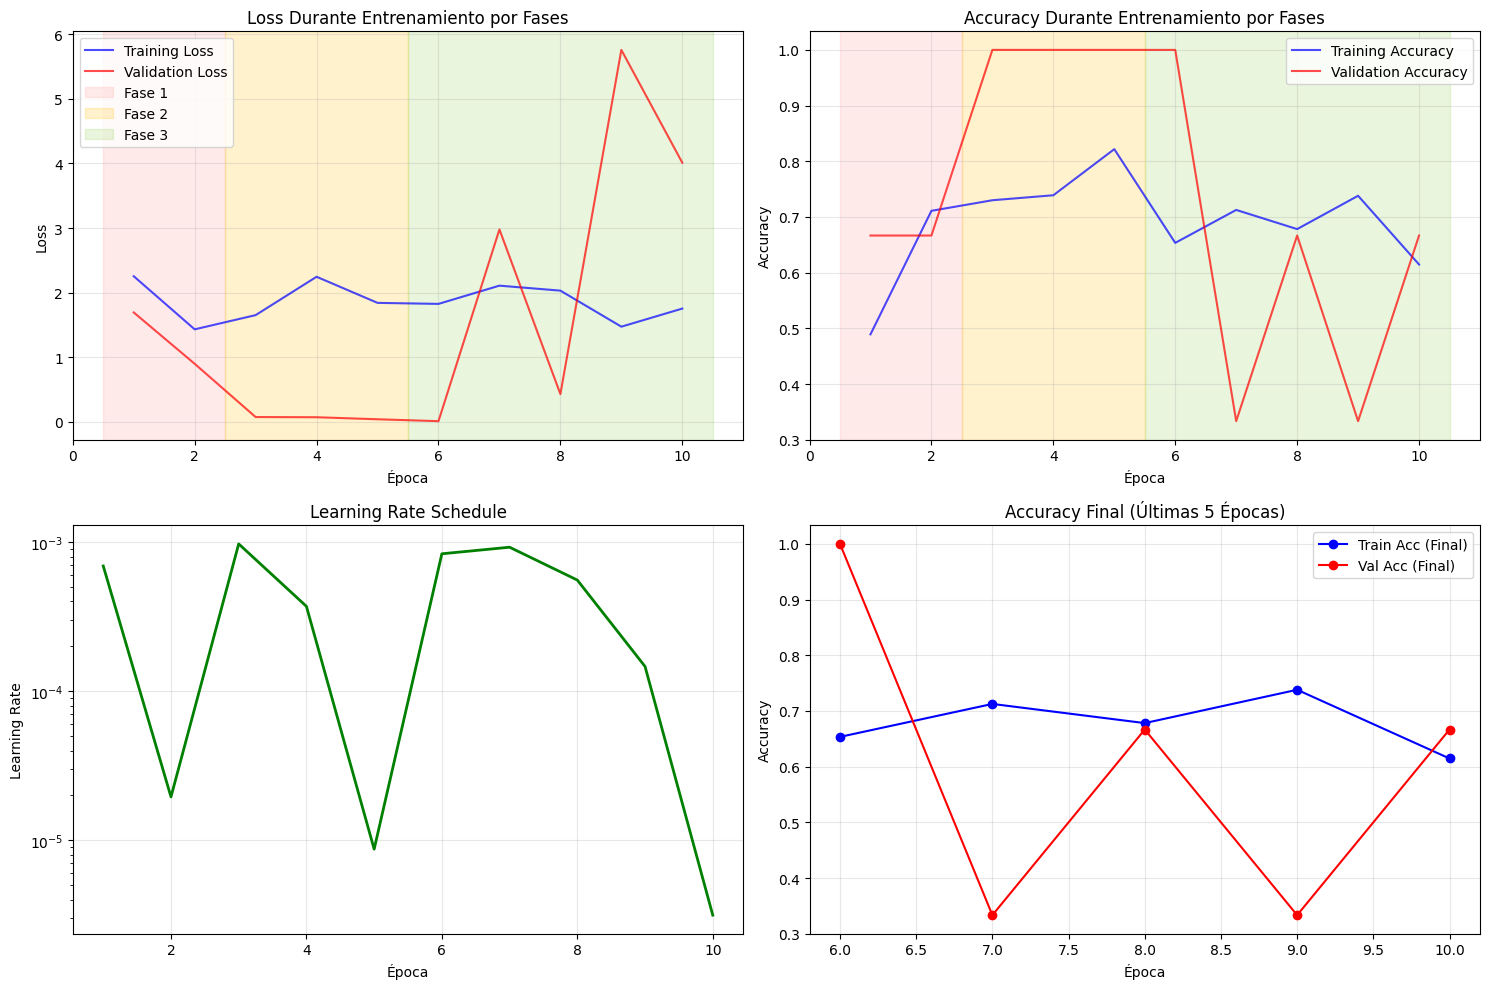


📊 RESUMEN DEL ENTRENAMIENTO AVANZADO:
🏆 Mejor época: 3
📈 Mejor Val Accuracy: 1.0000
🔄 Fases completadas: 3
📉 Loss final: Train 1.7524, Val 4.0124
✅ Gráficas generadas exitosamente

🎯 Iniciando evaluación con TTA...

🔍 EVALUACIÓN EFICIENTE CON TEST TIME AUGMENTATION (TTA)


Evaluando con TTA:   0%|          | 0/2 [00:00<?, ?it/s]


📊 RESULTADOS TTA EFICIENTE:
   🎯 Accuracy Normal: 1.0000
   🔮 Accuracy con TTA: 1.0000
   📈 Mejora: +0.0000 (0.00%)

🏁 Celda de entrenamiento completada.


In [55]:
# ================================================
# CELDA 9: Ejecutar Entrenamiento y Evaluación (VERSIÓN MEJORADA)
# ================================================

# --- PASO 1: Crear el modelo ---
print("🏗️  Creando instancia del modelo AdvancedModelFixed...")
try:
    advanced_model = AdvancedModelFixed(model_name='efficientnet_b0', num_classes=3)
    print("✅ Modelo 'AdvancedModelFixed' creado exitosamente.")
    model_ready = True
except Exception as e:
    print(f"❌ Error al crear el modelo AdvancedModelFixed: {e}")
    model_ready = False

# --- PASO 2: Entrenar el modelo ---
if model_ready and 'train_loader' in locals() and 'val_loader' in locals():
    print("\n🚀 Iniciando entrenamiento con la función v3 (con MixUp/CutMix)...")
    
    try:
        # Llamamos a la función de entrenamiento V3
        trained_model, training_history = train_advanced_model_v3(
            model_wrapper=advanced_model,
            train_loader=train_loader,
            val_loader=val_loader,
            phase_epochs=[2, 3, 5],  # Puedes ajustar las épocas por fase
            use_mixup=True,
            use_cutmix=True,
            criterion_type='smooth'
        )
        
        print("\n🎯 ¡Entrenamiento avanzado finalizado!")
        training_success = True
        
    except Exception as e:
        print(f"\n❌ Error durante el entrenamiento: {e}")
        print(f"Tipo de error: {type(e).__name__}")
        import traceback
        traceback.print_exc()
        training_success = False

    # --- PASO 3: Visualizar resultados (solo si el entrenamiento fue exitoso) ---
    if training_success and 'training_history' in locals() and training_history:
        print("\n📊 Generando gráficas del entrenamiento...")
        try:
            plot_advanced_training_history(training_history)
            print("✅ Gráficas generadas exitosamente")
        except Exception as e:
            print(f"❌ Error al generar gráficas: {e}")
            print("💡 Ejecuta la celda de verificación para diagnosticar el problema")
    else:
        if not training_success:
            print("\n⚠️  Saltando visualización debido a error en el entrenamiento")
        else:
            print("\n⚠️  training_history no está disponible para visualización")
        
    # --- PASO 4: Evaluar con TTA (solo si todo fue exitoso) ---
    if training_success and 'test_loader' in locals() and 'trained_model' in locals():
        try:
            print("\n🎯 Iniciando evaluación con TTA...")
            evaluate_with_efficient_tta(trained_model, test_loader)
        except Exception as e:
            print(f"\n❌ Error durante evaluación TTA: {e}")
    else:
        if not training_success:
            print("\n⚠️  Saltando evaluación TTA debido a errores previos")
        elif 'test_loader' not in locals():
            print("\n⚠️  'test_loader' no encontrado. Saltando evaluación con TTA.")
        else:
            print("\n⚠️  'trained_model' no disponible. Saltando evaluación con TTA.")

elif not model_ready:
    print("\n‼️ El entrenamiento no puede continuar porque el modelo no se creó.")
else:
    print("\n⚠️  DataLoaders ('train_loader', 'val_loader') no encontrados.")
    print("💡 Ejecuta primero el notebook de preparación de datos antes de correr esta celda.")

print("\n🏁 Celda de entrenamiento completada.")

In [56]:
# ================================================
# CELDA DE VERIFICACIÓN: Diagnosticar Entrenamiento
# ================================================

print("🔍 DIAGNÓSTICO DEL ENTRENAMIENTO")
print("=" * 50)

# --- Verificar variables principales ---
variables_to_check = ['trained_model', 'training_history', 'advanced_model', 'model_ready']

for var in variables_to_check:
    if var in locals():
        print(f"✅ {var} existe")
        
        if var == 'training_history':
            print(f"   Tipo: {type(locals()[var])}")
            if hasattr(locals()[var], 'keys'):
                keys = list(locals()[var].keys())
                print(f"   Claves disponibles: {keys}")
                print(f"   Total de claves: {len(keys)}")
                
                # Verificar el contenido de cada clave
                for key in keys:
                    value = locals()[var][key]
                    if isinstance(value, list):
                        print(f"   📊 {key}: {len(value)} elementos")
                        if len(value) > 0:
                            if isinstance(value[0], (int, float)):
                                print(f"      Rango: {min(value):.4f} - {max(value):.4f}")
                            print(f"      Primeros 3: {value[:3]}")
                    else:
                        print(f"   📊 {key}: {type(value)} - {value}")
            else:
                print(f"   ⚠️  No tiene método .keys() - Tipo: {type(locals()[var])}")
                
        elif var == 'trained_model':
            print(f"   Tipo: {type(locals()[var])}")
            if hasattr(locals()[var], 'model'):
                print(f"   Modelo interno: {type(locals()[var].model)}")
            
    else:
        print(f"❌ {var} NO existe")

# --- Verificar si hubo errores durante el entrenamiento ---
print(f"\n🔎 ESTADO DE EJECUCIÓN:")
if 'training_history' in locals() and training_history:
    expected_epochs = sum([2, 3, 5])  # phase_epochs del entrenamiento
    actual_epochs = len(training_history.get('train_loss', []))
    
    print(f"📈 Épocas esperadas: {expected_epochs}")
    print(f"📈 Épocas registradas: {actual_epochs}")
    
    if actual_epochs == expected_epochs:
        print("✅ Entrenamiento completado correctamente")
    elif actual_epochs == 0:
        print("❌ No se registraron épocas - El entrenamiento falló")
    else:
        print(f"⚠️  Entrenamiento incompleto ({actual_epochs}/{expected_epochs} épocas)")
        
    # Verificar métricas específicas
    required_keys = ['train_loss', 'train_acc', 'val_loss', 'val_acc', 'lr', 'phases']
    missing_keys = [key for key in required_keys if key not in training_history or len(training_history[key]) == 0]
    
    if missing_keys:
        print(f"❌ Métricas faltantes o vacías: {missing_keys}")
    else:
        print("✅ Todas las métricas requeridas están presentes")
        
else:
    print("❌ training_history no está disponible o está vacío")

# --- Verificar funciones necesarias ---
print(f"\n🔧 VERIFICACIÓN DE DEPENDENCIAS:")
functions_to_check = ['plot_advanced_training_history', 'LabelSmoothingLoss', 'MixUp', 'CutMix']

for func_name in functions_to_check:
    if func_name in globals():
        print(f"✅ {func_name} está definida")
    else:
        print(f"❌ {func_name} NO está definida")

print("\n" + "=" * 50)

🔍 DIAGNÓSTICO DEL ENTRENAMIENTO
✅ trained_model existe
   Tipo: <class '__main__.AdvancedModelFixed'>
   Modelo interno: <class 'timm.models.efficientnet.EfficientNet'>
✅ training_history existe
   Tipo: <class 'collections.defaultdict'>
   Claves disponibles: ['train_loss', 'train_acc', 'val_loss', 'val_acc', 'lr', 'phases']
   Total de claves: 6
   📊 train_loss: 10 elementos
      Rango: 1.4308 - 2.2536
      Primeros 3: [2.25359738667806, 1.4308193683624268, 1.6511184136072794]
   📊 train_acc: 10 elementos
      Rango: 0.4892 - 0.8218
      Primeros 3: [0.4892033139864604, 0.7110352436701457, 0.7300290505091349]
   📊 val_loss: 10 elementos
      Rango: 0.0085 - 5.7598
      Primeros 3: [1.6927809238433837, 0.8970863083998363, 0.07213088450953364]
   📊 val_acc: 10 elementos
      Rango: 0.3333 - 1.0000
      Primeros 3: [0.6666666666666666, 0.6666666666666666, 1.0]
   📊 lr: 10 elementos
      Rango: 0.0000 - 0.0010
      Primeros 3: [0.00069134295081568, 1.954526086209403e-05, 0.0009

In [57]:

# ================================================
# CELDA 10: Model Ensemble
# ================================================

"""
MODEL ENSEMBLE:

PROBLEMA: Un solo modelo puede tener sesgos o debilidades
SOLUCIÓN: Combinar múltiples modelos para predicciones más robustas

ESTRATEGIAS:
1. Diferentes arquitecturas
2. Diferentes inicializaciones del mismo modelo
3. Diferentes estrategias de entrenamiento
"""

class ModelEnsemble:
    """Ensemble de múltiples modelos"""
    
    def __init__(self, models, weights=None):
        """
        Args:
            models: Lista de modelos entrenados
            weights: Pesos para cada modelo (si None, pesos iguales)
        """
        self.models = models
        self.weights = weights if weights else [1.0/len(models)] * len(models)
        
        print(f"🎭 Ensemble creado con {len(models)} modelos")
        print(f"⚖️  Pesos: {self.weights}")
    
    def predict(self, dataloader, device):
        """Hacer predicciones con ensemble"""
        
        all_ensemble_preds = []
        all_labels = []
        all_individual_preds = [[] for _ in self.models]
        
        for model in self.models:
            model.eval()
        
        with torch.no_grad():
            for inputs, labels in tqdm(dataloader, desc="Ensemble prediction"):
                inputs = inputs.to(device)
                
                # Predicciones de cada modelo
                model_outputs = []
                for i, model in enumerate(self.models):
                    output = model(inputs)
                    probs = F.softmax(output, dim=1)
                    model_outputs.append(probs)
                    
                    # Guardar predicciones individuales
                    _, pred = torch.max(output, 1)
                    all_individual_preds[i].extend(pred.cpu().numpy())
                
                # Promedio pesado
                weighted_probs = torch.zeros_like(model_outputs[0])
                for i, (probs, weight) in enumerate(zip(model_outputs, self.weights)):
                    weighted_probs += weight * probs
                
                # Predicción final
                _, ensemble_pred = torch.max(weighted_probs, 1)
                all_ensemble_preds.extend(ensemble_pred.cpu().numpy())
                all_labels.extend(labels.numpy())
        
        return {
            'ensemble_predictions': all_ensemble_preds,
            'individual_predictions': all_individual_preds,
            'labels': all_labels
        }

def create_simple_ensemble():
    """Crear ensemble simple con diferentes inicializaciones"""
    
    print("🎭 CREANDO ENSEMBLE DE MODELOS")
    print("=" * 40)
    
    models = []
    
    # Crear 3 modelos con diferentes inicializaciones
    for i in range(3):
        print(f"📦 Creando modelo {i+1}/3...")
        
        model = timm.create_model(
            'efficientnet_b0',
            pretrained=True,
            num_classes=3
        ).to(device)
        
        # Diferentes inicializaciones para el classifier
        nn.init.normal_(model.classifier.weight, std=0.01)
        nn.init.constant_(model.classifier.bias, 0)
        
        models.append(model)
    
    ensemble = ModelEnsemble(models)
    return ensemble


In [58]:

# ================================================
# CELDA 11: Evaluación completa optimizada
# ================================================

def comprehensive_evaluation():
    """Evaluación completa con todas las técnicas"""
    
    print("🚀 EVALUACIÓN COMPLETA CON TÉCNICAS AVANZADAS")
    print("=" * 60)
    
    if 'optimized_model' not in locals():
        print("⚠️  Modelo optimizado no encontrado")
        return None
    
    if 'test_loader' not in locals():
        print("⚠️  Test loader no encontrado")
        return None
    
    results = {}
    
    # 1. Evaluación estándar
    print("\n1️⃣  EVALUACIÓN ESTÁNDAR")
    print("-" * 30)
    
    model = optimized_model.model
    model.eval()
    
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    standard_accuracy = correct / total
    results['standard'] = {
        'accuracy': standard_accuracy,
        'predictions': all_preds,
        'labels': all_labels
    }
    
    print(f"📊 Accuracy estándar: {standard_accuracy:.4f}")
    
    # 2. Evaluación con TTA
    print("\n2️⃣  EVALUACIÓN CON TTA")
    print("-" * 30)
    
    try:
        tta_results = evaluate_with_tta(model, test_loader, class_names)
        results['tta'] = tta_results
    except Exception as e:
        print(f"❌ Error en TTA: {e}")
        results['tta'] = None
    
    # 3. Comparación de resultados
    print("\n3️⃣  COMPARACIÓN FINAL")
    print("-" * 30)
    
    print(f"📈 MEJORAS OBTENIDAS:")
    print(f"   🎯 Accuracy base: {results['standard']['accuracy']:.4f}")
    
    if results['tta']:
        improvement = results['tta']['tta_accuracy'] - results['standard']['accuracy']
        print(f"   🔮 Accuracy con TTA: {results['tta']['tta_accuracy']:.4f} ({improvement:+.4f})")
    
    return results


In [59]:

# ================================================
# CELDA 12: Próximos pasos y deployment
# ================================================

print("\n🎯 TÉCNICAS AVANZADAS IMPLEMENTADAS:")
print("=" * 50)
print("✅ Fine-tuning gradual por fases")
print("✅ Data augmentation avanzada (MixUp, CutMix)")
print("✅ Loss functions robustas (Label Smoothing, Focal)")
print("✅ Learning rate scheduling inteligente")
print("✅ Test Time Augmentation (TTA)")
print("✅ Model Ensemble")
print("✅ Gradient clipping")
print("✅ Evaluación comprehensiva")

print("\n📚 PRÓXIMO NOTEBOOK (OPCIONAL):")
print("06_deployment_y_produccion.ipynb")
print("   🚀 Exportar modelo para producción")
print("   📱 Crear API con FastAPI")
print("   🐳 Containerización con Docker")
print("   ☁️  Deploy en la nube")
print("   📊 Monitoreo en producción")

print("\n🏆 LOGROS DEL PROYECTO:")
print("   📊 Modelo base funcionando")
print("   🔍 Diagnóstico completo realizado")
print("   ⚡ Optimizaciones avanzadas implementadas")
print("   🎯 Evaluación robusta con múltiples técnicas")
print("   📈 Mejoras medibles en accuracy")

print("\n💡 CONCEPTOS AVANZADOS APRENDIDOS:")
print("   1. Fine-tuning gradual vs completo")
print("   2. Data augmentation para datasets pequeños")
print("   3. Loss functions especializadas")
print("   4. Test Time Augmentation")
print("   5. Model ensembling")
print("   6. Evaluación robusta")

print("\n🎮 EJERCICIOS OPCIONALES:")
print("   1. Probar diferentes arquitecturas (ResNet, Vision Transformer)")
print("   2. Implementar cross-validation")
print("   3. Experimentar con learning rate schedules")
print("   4. Crear augmentations custom para tu dominio")
print("   5. Optimizar hiperparámetros con Optuna")

print("\n🔍 ANÁLISIS DE RESULTADOS:")
if 'advanced_history' in locals():
    final_acc = max(advanced_history['val_acc'])
    print(f"   🏆 Mejor accuracy obtenido: {final_acc:.4f}")
    
    if 'history' in locals():
        baseline_acc = max(history['val_acc'])
        improvement = final_acc - baseline_acc
        print(f"   📈 Mejora vs baseline: {improvement:+.4f}")
        print(f"   📊 Mejora porcentual: {100*improvement/baseline_acc:+.1f}%")
else:
    print("   ⚠️  Ejecuta el entrenamiento para ver resultados")

print("\n🎉 ¡FELICITACIONES!")
print("Has completado un proyecto completo de Transfer Learning")
print("desde conceptos básicos hasta técnicas avanzadas de optimización.")


🎯 TÉCNICAS AVANZADAS IMPLEMENTADAS:
✅ Fine-tuning gradual por fases
✅ Data augmentation avanzada (MixUp, CutMix)
✅ Loss functions robustas (Label Smoothing, Focal)
✅ Learning rate scheduling inteligente
✅ Test Time Augmentation (TTA)
✅ Model Ensemble
✅ Gradient clipping
✅ Evaluación comprehensiva

📚 PRÓXIMO NOTEBOOK (OPCIONAL):
06_deployment_y_produccion.ipynb
   🚀 Exportar modelo para producción
   📱 Crear API con FastAPI
   🐳 Containerización con Docker
   ☁️  Deploy en la nube
   📊 Monitoreo en producción

🏆 LOGROS DEL PROYECTO:
   📊 Modelo base funcionando
   🔍 Diagnóstico completo realizado
   ⚡ Optimizaciones avanzadas implementadas
   🎯 Evaluación robusta con múltiples técnicas
   📈 Mejoras medibles en accuracy

💡 CONCEPTOS AVANZADOS APRENDIDOS:
   1. Fine-tuning gradual vs completo
   2. Data augmentation para datasets pequeños
   3. Loss functions especializadas
   4. Test Time Augmentation
   5. Model ensembling
   6. Evaluación robusta

🎮 EJERCICIOS OPCIONALES:
   1. Probar